# Differential gene2gene variants between PCAWG and 1KG

Ideas:

- Use 1kg genefusion evidence to filter PCAWG results.
- Calculate global distribution of fusions
    - Any genefusion greater than median will be discarded
- Calculate local distribution of fusions (per gene)
    - Gene-wise filtering: for each gene, compute the top qth percentile of fusions in the genefusion count distribution. There is sufficient evidence these genefusions are common in the healthy population
    - Or, use median of medians instead of global median
- Population-wise filtering: compute the 95th percentile of normalized count for each gene's genefusion count distribution. Take a distribution of these 95th percentiles. Use the median or 95th percentile imposed on the 95th percentile distribution as filter criteria

## Imports

In [798]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import multiprocessing as mp
from functools import partial
import itertools
import math
import time
import datetime
import plotly.express as px
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns
import matplotlib.colors as mcolors
from PIL import Image
os.chdir('/data/jake/genefusion/scripts/python')
#cpus = mp.cpu_count()  // 2
cpus = 64
print(cpus)

64


## Data

### Known fusion genes

In [2]:
# from https://doi.org/10.1016/j.canlet.2013.01.011
df_known_fusions = pd.read_csv('/data/jake/genefusion/data/known_fusions.tsv', sep='\t')
df_known_fusions.head()

,Cancer,Cancer Type,Fusion Gene,Frequency,Mechanism of Formation,Biological Impact,References
0,Hematological cancers,Acute lymphocytic leukemia,ETV6-RUNX1,25%,Interchromosomal translocation,Oncogenic chimeric protein,"Golub et al. (1995), Romana et al. (1995)"
1,Hematological cancers,Acute lymphocytic leukemia,BCR-ABL1,15%,Interchromosomal translocation,Oncogenic chimeric protein,Westbrook et al. (1992)
2,Hematological cancers,Acute myeloid leukemia,RUNX1-ETO,10-15%,Interchromosomal translocation,Oncogenic chimeric protein,Erickson et al. (1992)
3,Hematological cancers,Acute myeloid leukemia,CBFB-MYH11,10-15%,Inversion,Oncogenic chimeric protein,Liu et al. (1993)
4,Hematological cancers,Acute promyelocytic leukemia,PML-RARA,95%,Interchromosomal translocation,Oncogenic chimeric protein,"Borrow et al. (1990), Warrell et al. (1991)"


In [3]:

df_known_fusions[df_known_fusions['Cancer Type'].str.match('Prostate', case = False)]

,Cancer,Cancer Type,Fusion Gene,Frequency,Mechanism of Formation,Biological Impact,References
29,Solid cancers,Prostate cancer,TMPRSS2-ERG,60%,Deletion,Promoter exchange,Tomlins et al. (2005)
30,Solid cancers,Prostate cancer,TMPRSS2-ETV1,0-5%,Interchromosomal translocation,Promoter exchange,Tomlins et al. (2005)
31,Solid cancers,Prostate cancer,TMPRSS2-ETV4,0-5%,Interchromosomal translocation,Promoter exchange,Tomlins et al. (2006)


In [4]:
dir_fig='/data/jake/genefusion/fig'

genes and locations

In [42]:
gene_file='/data/jake/genefusion/data/gene_file_cln.txt'
df_genes = pd.read_csv(gene_file, sep='\t', header = None)
df_genes.columns = ['chrm', 'start', 'end', 'gene', 'strand']
def gene_location(df_genes, gene):
    gene_row = df_genes[df_genes['gene'] == gene]
    chrm = gene_row['chrm'].values[0]
    start = gene_row['start'].values[0]
    end = gene_row['end'].values[0]
    
    return chrm, start, end
print(gene_location(df_genes, 'OR4F5'))
df_genes.head()
GENES=df_genes['gene'].values.tolist()
GENES = np.unique(GENES).tolist()
len(GENES)

('1', np.int64(69091), np.int64(70008))


26871

In [47]:
S = pd.Series(GENES)
mask = S.str.contains('ACE')
S[mask]

1166             ACE
1167            ACE2
1168           ACER1
1169           ACER2
1170           ACER3
2773           BACE1
2774           BACE2
2775     BACE2negIT1
2935           BLACE
9594           HACE1
11859          LACE1
dtype: object

In [4]:
# pd.Series(GENES).value_counts().sort_values(ascending=False).head()

- Duplicate gene names exist: 
    - Example: NPIPA7,TM9SF1, etc.
    - from '/data/jake/genefusion/data/gene_file.txt' there is a pattern. The duplicate genes are located on the same chromosome. The difference is that the start and end points vary slightly.
    - Adress this by recording the gene chrm, start, end region
    

In [135]:
# def add_suffix_to_duplicates(strings):
#     count = {}
#     result = []
#     for s in strings:
#         if s in count:
#             count[s] += 1
#             result.append(f"{s}_{count[s]}")
#         else:
#             count[s] = 0
#             result.append(s)
#     return result
# GENES = add_suffix_to_duplicates(GENES)
# [x for x in GENES if '_' in x][:2]

In [6]:
df_genes['gene_loc'] = df_genes.apply(
    lambda row: f'{row["gene"]}_{row["chrm"]}_{row["start"]}_{row["end"]}', 
    axis=1
)
print(df_genes['gene'].unique().shape,df_genes['gene_loc'].unique().shape)
df_genes.head()

(26871,) (26954,)


,chrm,start,end,gene,strand,gene_loc
0,1,69091,70008,OR4F5,pos,OR4F5_1_69091_70008
1,1,134901,139379,AL627309.1,neg,AL627309.1_1_134901_139379
2,1,139790,140339,RP11neg34P13.14,neg,RP11neg34P13.14_1_139790_140339
3,1,367640,368634,OR4F29,pos,OR4F29_1_367640_368634
4,1,621059,622053,OR4F16,neg,OR4F16_1_621059_622053


In [7]:
df_genes['chrm'].unique()

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y'],
      dtype=object)

In [93]:
# GENES_W_LOC = df_genes['gene_loc'].values.tolist()
# GENES_W_LOC.sort()
# GENES_W_LOC[:5]

['7SK_8_144624280_144624570',
 'A1BG_19_58856544_58864865',
 'A1BGnegAS1_19_58859117_58866549',
 'A1CF_10_52559169_52645435',
 'A2ML1_12_8975068_9039597']

## 1kg

In [8]:
#dir_pcawg = '/data/jake/genefusion/data/2024_10_31-fusions'
dir_1kg = '/data/jake/genefusion/data/2024_11_01-fusions-1kg'
dir_1kg_fusions = os.path.join(dir_1kg, 'fusions_cln')

In [9]:
os.listdir(dir_1kg_fusions)[0:5]

['1.neg.ZNF669.247263264.247267674.fusions',
 '17.neg.CCL3.34415602.34417515.fusions',
 '20.pos.VAPB.56964178.57026157.fusions',
 '10.pos.RP11neg162G10.5.38146668.38148038.fusions',
 '11.neg.RP5neg901A4.1.67792277.67797928.fusions']

In [10]:
fusionfiles = glob.glob(os.path.join(dir_1kg_fusions, '*.fusions'))
print(len(fusionfiles))
# filter out empty files
#fusionfiles = [f for f in fusionfiles if os.stat(f).st_size > 0]
print(len(fusionfiles))

26954
26954


### ERG (chrm 21 neg)

In [172]:
regex = re.compile('21\\.neg\\.ERG')
regex
for file in os.listdir(dir_1kg_fusions):
    if regex.search(file):
        ergfile = file
try: 
    ergfile
except NameError:
    print('No ERG file found')

In [98]:
df_erg = pd.read_csv(os.path.join(dir_1kg_fusions, ergfile), sep='\t',header=None)
df_erg.columns = ['chrm', 'start', 'end', 'gene', 'strand']
df_erg.head()

,chrm,start,end,gene,strand
0,21,39756323,39756358,ERG,neg
1,21,39756691,39756781,ERG,neg
2,21,39760265,39760366,ERG,neg
3,21,39755190,39755292,ERG,neg
4,21,39753426,39753527,ERG,neg


#### Mode

In [10]:
# including self
print(df_erg['gene'].mode())
print(df_erg['gene'].value_counts().max())
# self value
# non-self
print(df_erg['gene'][df_erg['gene'] != 'ERG'].mode())
# mode value
df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().max()

0    ERG
Name: gene, dtype: object
9813
0    DMD
Name: gene, dtype: object


np.int64(111)

#### Count ranks and distributions

In [294]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
counts.head()

[ 1.   3.   7.  21.5]


gene
DMD         111
TM4SF2       99
LARGE        78
IL1RAPL1     73
DSCAM        61
Name: count, dtype: int64

In [ ]:
count

[0.         0.47712125 0.84509804 1.35111   ]


[]

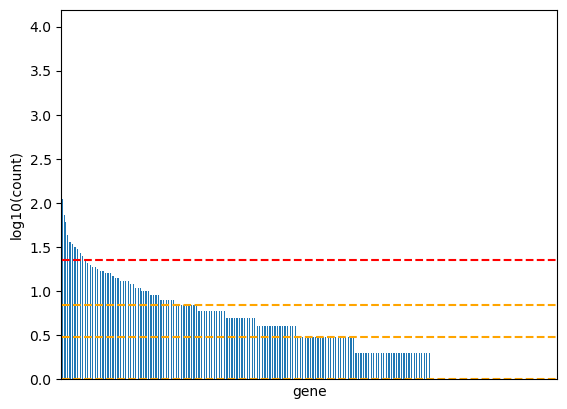

In [293]:
counts = df_erg['gene'].value_counts().apply(lambda x: np.log10(x))
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
print(qs)
ax = counts.plot(kind='bar', )
ax.hlines(y=qs[0:3], xmin=0, xmax=counts.shape[0], color='orange', linestyle='--')
ax.hlines(y=qs[3], xmin=0, xmax=counts.shape[0], color='red', linestyle='--')

ax.set_ylabel('log10(count)')
ax.set_xticks([])  
ax.set_xticklabels([]) 

##### >= 95th% counts

In [154]:
counts = df_erg['gene'][df_erg['gene'] != 'ERG'].value_counts().sort_values(ascending=False)
qs = np.quantile(counts, [0.25, 0.5, 0.75, 0.95])
counts_95 = counts[counts > qs[3]]
counts_95

gene
DMD          111
TM4SF2        99
LARGE         78
IL1RAPL1      73
DSCAM         61
MTnegND5      53
TTC28         47
SYN3          44
MTnegND4      44
MTnegRNR2     42
DHRSX         36
MTnegCO1      36
NLGN4X        36
FRMPD4        35
MTnegCYB      34
ARHGAP6       34
RBFOX2        33
MTnegCO3      32
PCDH11Y       32
MTnegRNR1     31
FAM19A5       30
CECR2         30
MKL1          30
TBC1D22A      30
TNRC6B        29
EFCAB6        27
NHS           25
MTnegND6      25
PACSIN2       25
REPS2         25
MTnegATP6     24
MTnegND1      24
MTnegND2      23
KIAA1671      23
MID1          22
Name: count, dtype: int64

This is the set we'd like to subtract from PCAWG population

#### Mobility tendency

##### 95th percentile

In [63]:
counts_95.index.tolist()[0:5]

['DMD', 'TM4SF2', 'LARGE', 'IL1RAPL1', 'DSCAM']

In [81]:
locations_95 = {}
for gene in counts_95.index:
    locations_95[gene] = gene_location(df_genes, gene)
locations_95 = pd.DataFrame.from_dict(locations_95, orient='index', columns=['chrm', 'start', 'end'])
locations_95.chrm.value_counts()

chrm
22    12
MT    11
X     10
21     1
Y      1
Name: count, dtype: int64

### Population stats

Normalize counts to [0,1] frequencies for comparison across populations

In [151]:
def get_95(fusionfile, normalize=False):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize)\
        .sort_values(ascending=False)
    q = float(np.quantile(counts, 0.95))
    return q
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions')))
print(get_95(os.path.join(dir_1kg_fusions, '21.neg.ERG.39751949.40033704.fusions'), normalize=True))

21.5
0.004821708903341556


In [125]:
%%capture
with mp.Pool(processes=cpus) as pool:
    dist_95 = pool.map(get_95, fusionfiles)
dist_95[0:5]

In [129]:
filt_95 = [x for x in dist_95 if x is not None]
filt_95[0:5]

[2.0, 4.3999999999999915, 8.5, 1.0, 2.0]

In [130]:
pd.Series(filt_95).describe()

count    25924.000000
mean         7.174452
std         22.957931
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max       2563.600000
dtype: float64

In [131]:
pd.Series(filt_95).quantile(0.95)

np.float64(22.0)

- Median of 95th percentile distribution is 4

- 95th of 95th percentile distribution is 22

#### Normalized counts

In [134]:
%%capture
normalize = True
with mp.Pool(processes=cpus) as pool:
    get_95_norm = partial(get_95, normalize=normalize)
    dist_95_norm = pool.map(get_95_norm,fusionfiles)
dist_95_norm[0:5]

In [135]:
filt_95_norm = [x for x in dist_95_norm if x is not None]
filt_95_norm[0:5]

[0.0008090614886731392,
 0.030344827586206838,
 0.005286069651741294,
 0.004424778761061947,
 0.0014124293785310734]

In [137]:
pd.Series(filt_95_norm).describe()

count    25924.000000
mean         0.008536
std          0.044347
min          0.000067
25%          0.000509
50%          0.001144
75%          0.003602
max          1.000000
dtype: float64

In [138]:
pd.Series(filt_95_norm).quantile(0.95)

np.float64(0.019417475728155338)

Use the preceeding results as a gene-wise filter for PCAWG.

Example

If a genefusion has a relative frequency of >20% (95th%tile) within its count distribution in the 1000 genomes population, then ignore it in PCAWG population.

##### Gene-wise filtering

In [169]:
def healthy_fusions(fusionfile, q = 0.95, normalize=True):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None)
    df.columns = ['chrm', 'start', 'end', 'gene', 'strand']
    counts = df['gene'][df['gene'] != gene].value_counts(normalize=normalize).sort_values(ascending=False)
    qp = float(np.quantile(counts, q))
    h_fusions = counts[counts > qp].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

['ERG+DMD',
 'ERG+TM4SF2',
 'ERG+LARGE',
 'ERG+IL1RAPL1',
 'ERG+DSCAM',
 'ERG+MTnegND5',
 'ERG+TTC28',
 'ERG+SYN3',
 'ERG+MTnegND4',
 'ERG+MTnegRNR2',
 'ERG+DHRSX',
 'ERG+MTnegCO1',
 'ERG+NLGN4X',
 'ERG+FRMPD4',
 'ERG+MTnegCYB',
 'ERG+ARHGAP6',
 'ERG+RBFOX2',
 'ERG+MTnegCO3',
 'ERG+PCDH11Y',
 'ERG+MTnegRNR1',
 'ERG+FAM19A5',
 'ERG+CECR2',
 'ERG+MKL1',
 'ERG+TBC1D22A',
 'ERG+TNRC6B',
 'ERG+EFCAB6',
 'ERG+NHS',
 'ERG+MTnegND6',
 'ERG+PACSIN2',
 'ERG+REPS2',
 'ERG+MTnegATP6',
 'ERG+MTnegND1',
 'ERG+MTnegND2',
 'ERG+KIAA1671',
 'ERG+MID1']

In [170]:
%%capture
with mp.Pool(processes=cpus) as pool:
    h_fusions = pool.map(healthy_fusions, fusionfiles)

In [171]:
len(list(itertools.chain.from_iterable(h_fusions)))

3786645

In [174]:
%%capture
with mp.Pool(processes=cpus) as pool:
    partial_healthy_fusions = partial(healthy_fusions, q=0.5, normalize=True)
    h_fusions_med = pool.map(partial_healthy_fusions, fusionfiles)

In [175]:
len(list(itertools.chain.from_iterable(h_fusions_med)))

34375533

Median filtering

- Compute genefusion median per gene
- Take median of medians
- Filter any genefusion above median count

In [191]:
def gene_wise_median(fusionfile):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = ['gene']
    median = int(df['gene'].value_counts().median())
    return median
gene_wise_median('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')   

3

In [195]:
with mp.Pool(processes=cpus) as pool:
    medians = pool.map(gene_wise_median, fusionfiles)

In [198]:
# median of medians
np.median(medians)

np.float64(1.0)

Text(0.5, 1.0, 'Distribution of gene-wise median fusion counts')

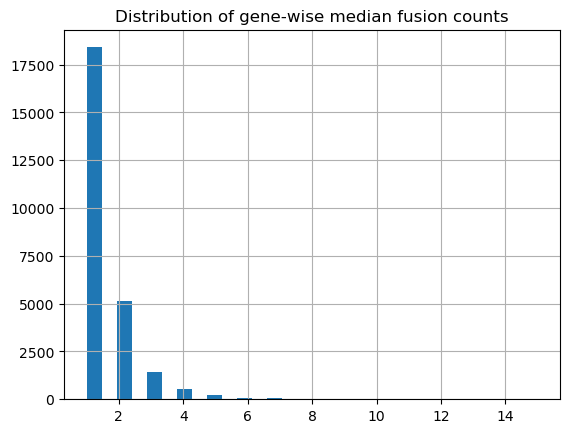

In [205]:
pd.Series(medians).hist(bins=30)
plt.title('Distribution of gene-wise median fusion counts')

In [208]:
pd.Series(medians).value_counts()

1     18404
2      5134
3      1435
4       536
5       199
6        86
7        60
8        32
9        12
10        9
11        6
12        5
13        4
15        1
14        1
Name: count, dtype: int64

Applying >1 filter to all genefusion pairs

In [207]:
def healthy_fusions(fusionfile, threshold=1):
    base = os.path.basename(fusionfile)
    gene = base.split('.')[2]
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = ['gene']
    counts = df['gene'][df['gene'] != gene].value_counts()
    h_fusions = counts[counts > threshold].index.tolist()
    h_fusions = [f'{gene}+{x}' for x in h_fusions]
    return h_fusions
healthy_fusions('/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions/21.neg.ERG.39751949.40033704.fusions')[0:5]

['ERG+DMD', 'ERG+TM4SF2', 'ERG+LARGE', 'ERG+IL1RAPL1', 'ERG+DSCAM']

In [211]:
outfile_hf= '/data/jake/genefusion/data/healthy_fusions.txt'
def helper(fusionsfile, outfile= outfile_hf):
    with open(outfile, 'a') as f:
        hf = healthy_fusions(fusionsfile, threshold=1)
        for line in hf:
            f.write(line + '\n')
with mp.Pool(processes=cpus) as pool:
    pool.map(helper, fusionfiles)
    

In [215]:
with open(outfile_hf, 'rb') as f:
    n_hf = sum(1 for _ in f)
print(n_hf)
print(n_hf * 10 ** -6, 'M')

48336949
48.336949 M


In [222]:
comb = math.comb(27000,2) * 10 ** -6
comb

364.4865

### Summary

- 3.8M genefusions filtered out by gene-wise 95th percentile
- 34M genefusions filtered out by gene-wise median
- 48M genefusions filtered by median of means (gene fusion count >1)

### Fusion count matrix

- notes:
  - some genes had no fusions
  - some genes have 'gene.2' naming; '.' is the same delimiter I used for file naming.
    - Can still parse from filenames by using forward and reverse splits
      - Example: filename.split('.')[2] -> strand; filename.split('.')[-3] -> start

In [11]:
def filestring2data(string):
    # assumes .giggle extension
    chrm = string.split('.')[0]
    strand = string.split('.')[1]
    gene = string.split('.')[2]
    start = string.split('.')[-3]
    end = string.split('.')[-2]
    # handle rare case where gene name has a period
    if len(string.split('.')) >= 7:
        gene = '.'.join(string.split('.')[2:-3])
    return [chrm, strand, gene, start, end]

In [12]:
# filestring2data('21.neg.ERG.39751949.40033704.giggle')
filestring2data('1.pos.RP3neg426I6.5.28100369.28100552.fusions')

['1', 'pos', 'RP3neg426I6.5', '28100369', '28100552']

In [176]:
# non_std_chrm_genes = []
# files_nscg= os.listdir('/data/jake/genefusion/data/2024_11_01-fusions-1kg/non_std_chr_fusions')
# g_exclude = list(map(filestring2data, files_nscg))
# g_exclude = [x[2] for x in g_exclude]
# g_exclude

In [13]:
print(len(fusionfiles),len(GENES))

26954 26871


In [14]:
def count_gene_var_pairs(fusionfile, GENES=GENES):
    base = os.path.basename(fusionfile)
    gene = str(base.split('.')[2])
    chrm,strand,gene,start,end = filestring2data(base) 
    df = pd.read_csv(fusionfile, sep='\t', header=None, usecols=[3])
    df.columns = [gene]
    counts = df[gene].value_counts()
    counts.name = gene
    return counts
znf = count_gene_var_pairs(fusionfiles[0]).head()
    

In [179]:
fusionfiles[0]

'/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions_cln/1.neg.ZNF669.247263264.247267674.fusions'

In [180]:
znf.name

'ZNF669'

In [181]:
fusionfiles_not_empty = [f for f in fusionfiles if os.stat(f).st_size > 0]
fusionfiles_empty = [f for f in fusionfiles if os.stat(f).st_size == 0]
fusionfiles_empty[:5]

['/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions_cln/X.neg.SRPX.38008589.38080696.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions_cln/X.neg.TAF7L.100523241.100548059.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions_cln/Y.neg.FAM197Y8.9185120.9193010.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions_cln/X.pos.NXF2.101470280.101581634.fusions',
 '/data/jake/genefusion/data/2024_11_01-fusions-1kg/fusions_cln/X.neg.NAA10.153194695.153200676.fusions']

In [182]:
empty_genes = [os.path.basename(f).split('.')[2] for f in fusionfiles_empty]
print(len(empty_genes))
empty_genes[:5]

1030


['SRPX', 'TAF7L', 'FAM197Y8', 'NXF2', 'NAA10']

In [183]:
cpus = 64
with mp.Pool(processes=cpus) as pool:
    gene_var_pairs = pool.map(count_gene_var_pairs, fusionfiles_not_empty)

In [186]:
print(type(gene_var_pairs[0]))
print(gene_var_pairs[0].shape)
gene_var_pairs[0].head()

<class 'pandas.core.series.Series'>
(1962,)


ZNF669
ARID2     90
ZNF669    67
RPH3AL     9
ROBO2      6
MDGA2      6
Name: ZNF669, dtype: int64

In [187]:
def compute_row(gene_var_pairs_ser):
    source = gene_var_pairs_ser.name
    blank = pd.Series(0, index=GENES, dtype=np.int64)
    for target, count in gene_var_pairs_ser.items():
        blank.loc[target] += count
    blank.name = source
    return blank
compute_row(gene_var_pairs[0]).head()

7SK           0
A1BG          0
A1BGnegAS1    0
A1CF          1
A2M           0
Name: ZNF669, dtype: int64

In [253]:
# # this takes far too long (~10 hours; try using shared array and parallelizing entry filling)
# n = len(GENES)
# A = np.zeros((n,n),dtype=np.int64)
# A = pd.DataFrame(A, index=GENES, columns=GENES)
# # i = 0
# for source in gene_var_pairs:
#     for target, count in source.items():
#         A.loc[source.name, target] += count
#     # i += 1
#     # if i >=10:
#     #     break
# # mask = A.index.str.contains('RP3neg508I15')
# # A[mask]

In [188]:
cpus=64
with mp.Pool(cpus) as pool:
    results = pool.map(compute_row, gene_var_pairs)
H = pd.DataFrame(results)
H.sort_index(inplace=True)
# combine result of duplicate gene names
H = H.groupby(H.index).sum()
H.to_csv('/data/jake/genefusion/data/1kg-gene_var_pairs.csv',sep='\t')

In [189]:
H.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [269]:
# likely unused
# sort fusionfiles by gene name
# df_fusionfiles = pd.DataFrame(fusionfiles, columns=['file'])
# df_fusionfiles['gene_loc'] = df_fusionfiles['file'].apply(lambda x: filestring2data(os.path.basename(x)))
# # reorder
# df_fusionfiles['gene_loc'] = df_fusionfiles['gene_loc'].apply(lambda x: f'{x[2]}_{x[0]}_{x[3]}_{x[4]}')
# df_fusionfiles_sort = df_fusionfiles.sort_values('gene_loc').reset_index(drop=True)
# df_fusionfiles_sort

In [270]:
# for i, file in enumerate(df_fusionfiles_sort['file'].values):
#     print(file)
#     base_i = os.path.basename(file)
#     gene_i = base_i.split('.')[2]
#     fusions = pd.read_csv(file, sep='\t', header=None, usecols=[3])
#     fusions.columns = ['gene']
#     fusions = fusions['gene'].value_counts().sort_values(ascending=False)
#     for gene in GENES:
#         if not gene in fusions.index.tolist():
#             # fill absent genes with 0
#             fusions.loc[gene] = 0
#     break
# fusions

In [64]:
H = H.groupby(H.index).sum()
npz_path = '/data/jake/genefusion/data/1kg-gene_var_pairs.npz'
np.savez_compressed(npz_path, data = H.to_numpy(), columns=H.columns.to_numpy(), index=H.index.to_numpy())

In [16]:
loaded = np.load(npz_path, allow_pickle=True)

H = pd.DataFrame(
     loaded["data"],
     columns=loaded["columns"],
     index=loaded["index"]
 )
del loaded

H.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


### Burden

- Source is row index
- Target is col index

Housekeeping genes

    GAPDH (Glyceraldehyde 3-phosphate dehydrogenase)
    HPRT1 (Hypoxanthine phosphoribosyltransferase 1)
    SDHA (Succinate dehydrogenase complex flavoprotein subunit A)
    B2M (Beta-2-microglobulin)
    UBC (Ubiquitin C)
    YWHAZ (Tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein zeta)
    ATF1, ATF2, ATF4, ATF6, ATF7 (Activating transcription factors)
    BTF3 (Basic transcription factor 3)
    E2F4 (E2F transcription factor 4)
    ERH (Enhancer of rudimentary homolog)
    HMGB1 (High mobility group box 1)
    ILF2 (Interleukin enhancer binding factor 2)


In [409]:
GENES_HK = {'GAPDH', 'HPRT1', 'SDHA', 'B2M', 'UBC', 'YWHAZ', 'ATF1', 'ATF2', 'ATF4', 'ATF6', 'ATF7', 'BTF3', 'E2F4', 'ERH', 'HMGB1', 'ILF2'}
GENES_HK2 = {
    "ACTB",
    "TUBB",
    "RPL13A",
    "PPIA",
    "TBP",
}
GENES_PC = {'TP53', 'RB1', 'PTEN', 'FOXA1', 'CDK12', 'AR', 'SPOP', 'LSAMP', 'PTPRD'}

In [73]:
npz_path = '/data/jake/genefusion/data/1kg-gene_var_pairs.npz'
loaded = np.load(npz_path, allow_pickle=True)
H = pd.DataFrame(
    loaded["data"],
    columns=loaded["columns"],
    index=loaded["index"]
)
del loaded
print(H.shape)
H.head()

(25842, 26871)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


#### Distinct

- Gene pair variant burden (distinct): For a source gene, count the number of distinct target genes with SV evidence. Yes -> 1, no -> 0

In [77]:
cpus = 64 
def count2bool(count):
    return int(count > 0)
def process_chunk(df_chunk):
    return df_chunk.map(count2bool)
chunks = np.array_split(H, cpus)
with mp.Pool(cpus) as pool:
    results = pool.map(process_chunk, chunks)
H_distinct = pd.concat(results)

/data/jake/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [78]:
npz_path = '/data/jake/genefusion/data/1kg-gene_var_pairs_distinct.npz'
np.savez_compressed(npz_path, data = H_distinct.to_numpy(), columns=H_distinct.columns.to_numpy(), index=H_distinct.index.to_numpy())

In [18]:
loaded = np.load(npz_path, allow_pickle=True)
H_distinct = pd.DataFrame(
    loaded["data"],
    columns=loaded["columns"],
    index=loaded["index"]
)
del loaded

In [79]:
H_distinct.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
A2M,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Burden = row_sum + col_sum - 2
- -2 for self counts in both row and col

In [90]:
# cannot parallelize with df as argument, too much memory
# instead pass in only the row and col as necessary
def burden_distinct(gene,ser_row,ser_col):
    # -2 for self counts in both row and col
    s = ser_row.sum() + ser_col.sum() - 2
    return np.int64(s)
burden_distinct('A1CF', H_distinct.loc['A1CF',:], H_distinct.loc[:,'A1CF'])
    

np.int64(11258)

In [91]:
H_distinct.loc['A1CF',:].sum() +\
H_distinct.loc[:,'A1CF'].sum() - 2

np.int64(11258)

In [92]:
# make sure to only loop row idx since some genes are excluded if empty
# columns contain all possible genes
queries_H_d = []
for g in H_distinct.index:
    # gene, row, col
    queries_H_d.append((g, H_distinct.loc[g,:], H_distinct.loc[:, g]))
queries_H_d[1]

('A1BG',
 7SK                 0
 A1BG                1
 A1BGnegAS1          1
 A1CF                0
 A2M                 0
                    ..
 ZZZ3                0
 hsanegmirneg1199    0
 hsanegmirneg150     0
 hsanegmirneg335     0
 hsanegmirneg490     0
 Name: A1BG, Length: 26871, dtype: int64,
 7SK                 0
 A1BG                1
 A1BGnegAS1          1
 A1CF                1
 A2M                 0
                    ..
 ZZZ3                0
 hsanegmirneg1199    0
 hsanegmirneg150     0
 hsanegmirneg335     0
 hsanegmirneg490     0
 Name: A1BG, Length: 25842, dtype: int64)

In [93]:
H_burd_distinct = {}
for i,x in enumerate(queries_H_d):
    gene, ser_row, ser_col = x
    print(i,gene)
    H_burd_distinct[gene] = burden_distinct(gene, ser_row, ser_col)

0 7SK
1 A1BG
2 A1BGnegAS1
3 A1CF
4 A2M
5 A2ML1
6 A2ML1negAS1
7 A2ML1negAS2
8 A2MnegAS1
9 A3GALT2
10 A4GALT
11 A4GNT
12 AAAS
13 AACS
14 AADAC
15 AADACL2
16 AADACL3
17 AADACL4
18 AADAT
19 AAED1
20 AAGAB
21 AAK1
22 AAMDC
23 AAMP
24 AANAT
25 AAR2
26 AARD
27 AARS
28 AARS2
29 AARSD1
30 AASDH
31 AASDHPPT
32 AASS
33 AATF
34 AATK
35 AATKnegAS1
36 ABAT
37 ABCA1
38 ABCA10
39 ABCA12
40 ABCA13
41 ABCA2
42 ABCA3
43 ABCA4
44 ABCA5
45 ABCA6
46 ABCA7
47 ABCA8
48 ABCA9
49 ABCA9negAS1
50 ABCB1
51 ABCB10
52 ABCB11
53 ABCB4
54 ABCB5
55 ABCB6
56 ABCB8
57 ABCB9
58 ABCC1
59 ABCC10
60 ABCC11
61 ABCC12
62 ABCC2
63 ABCC3
64 ABCC4
65 ABCC5
66 ABCC5negAS1
67 ABCC6
68 ABCC8
69 ABCC9
70 ABCD2
71 ABCD3
72 ABCD4
73 ABCE1
74 ABCF1
75 ABCF2
76 ABCF3
77 ABCG1
78 ABCG2
79 ABCG4
80 ABCG5
81 ABCG8
82 ABHD1
83 ABHD10
84 ABHD11
85 ABHD12
86 ABHD12B
87 ABHD13
88 ABHD14A
89 ABHD14AnegACY1
90 ABHD14B
91 ABHD15
92 ABHD16A
93 ABHD16B
94 ABHD17A
95 ABHD17B
96 ABHD17C
97 ABHD2
98 ABHD3
99 ABHD4
100 ABHD5
101 ABHD6
102 ABHD8
103 ABI1

ERG    17238
dtype: int64 TMPRSS2    11183
dtype: int64


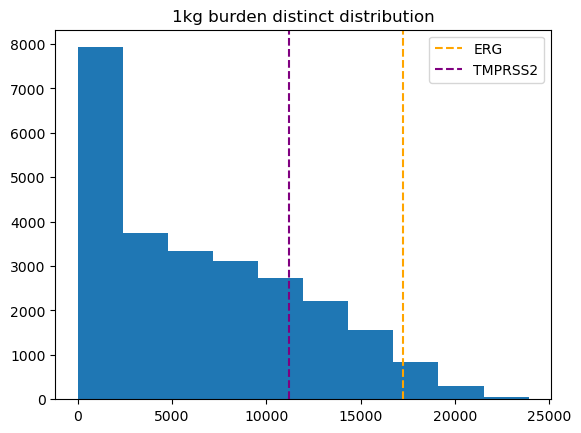

In [139]:
H_burd_distinct_ser = pd.Series(H_burd_distinct)
H_burd_distinct_ser.hist()

mask_erg = H_burd_distinct_ser.index.str.contains('^ERG$')
mask_tmprss2 = H_burd_distinct_ser.index.str.contains('^TMPRSS2$')
a = H_burd_distinct_ser[mask_erg]
b = H_burd_distinct_ser[mask_tmprss2]
print(a,b)

plt.title('1kg burden distinct distribution')
plt.grid(False)
plt.axvline(x=a.values, color='orange', linestyle='--')
plt.axvline(x=b.values, color='purple', linestyle='--')
plt.legend(['ERG', 'TMPRSS2'])

In [347]:
# H_burd_distinct = pd.DataFrame(H_burd_distinct, columns=['gene', 'burden'])
# H_burd_distinct.burden.describe()

count     25924
unique    13043
top         376
freq         18
Name: burden, dtype: int64

/tmp/ipykernel_158195/2252010242.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




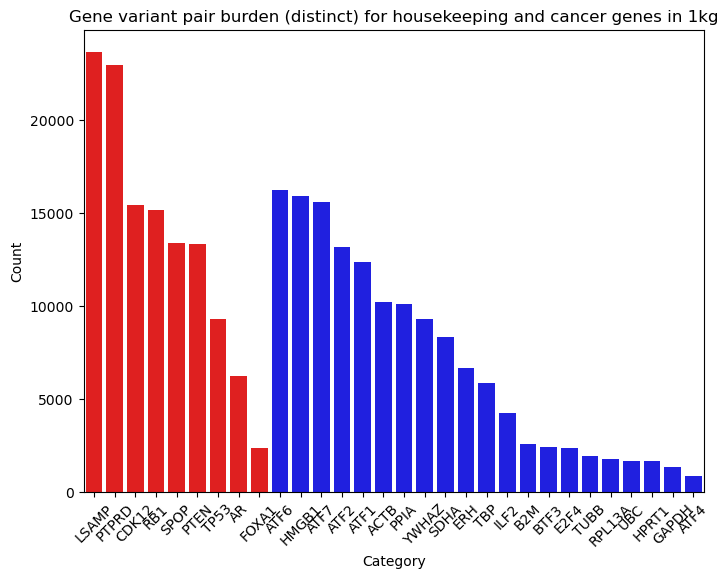

In [423]:
mask = [i for i in burden_distincts_ser.index.tolist() if i in GENES_HK.union(GENES_PC, GENES_HK2)]
df_burden_sub = pd.DataFrame(burden_distincts_ser[mask])
df_burden_sub['color'] = df_burden_sub.index.map(lambda x: 'red' if x in GENES_PC else 'blue')
df_burden_sub.columns = ['count', 'color']
df_burden_sub.sort_values(['color', 'count'], ascending=False, inplace=True)
df_burden_sub['length'] = df_burden_sub.index.map(lambda x: gene_location(df_genes, x)[2] - gene_location(df_genes, x)[1])
df = df_burden_sub
df.head()
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y='count', data=df, palette=df['color'].tolist())

# # Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Gene variant pair burden (distinct) for housekeeping and cancer genes in 1kg')
plt.xticks(rotation=45)


# Show the plot
plt.show()

/tmp/ipykernel_158195/3347778395.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




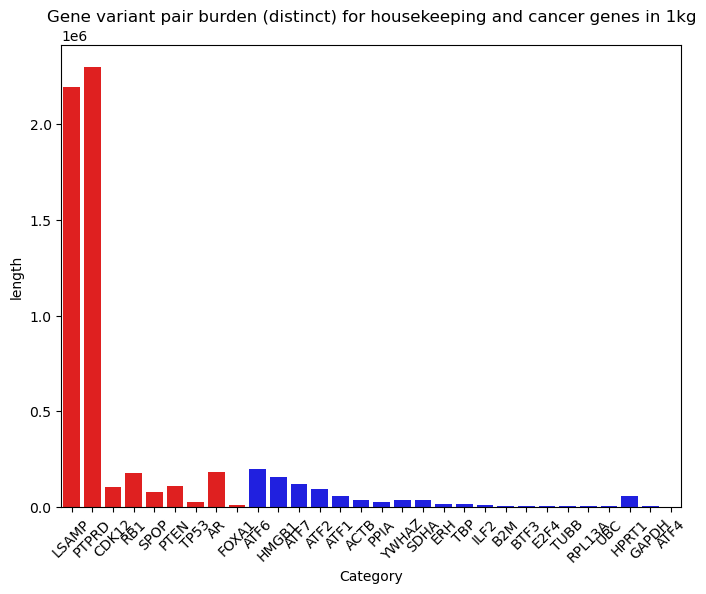

In [424]:
#df = df.sort_values(['color', 'length'], ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y='length', data=df, palette=df['color'].tolist())

# # Add labels and title
plt.xlabel('Category')
plt.ylabel('length')
plt.title('Gene variant pair burden (distinct) for housekeeping and cancer genes in 1kg')
plt.xticks(rotation=45)


# Show the plot
plt.show()

##### Distinct burden and length correlation


In [427]:
print(117716095 - 115521235, 37721160 - 37617764)

2194860 103396


In [98]:
H_burd_distinct_df = H_burd_distinct_ser.to_frame()
H_burd_distinct_df.columns = ['count']
H_burd_distinct_df['length'] = H_burd_distinct_df.index.map(lambda x: gene_location(df_genes, x)[2] - gene_location(df_genes, x)[1])
H_burd_distinct_df.head()


,count,length
7SK,188,290
A1BG,3590,8321
A1BGnegAS1,2929,7432
A1CF,11258,86266
A2M,8594,48565


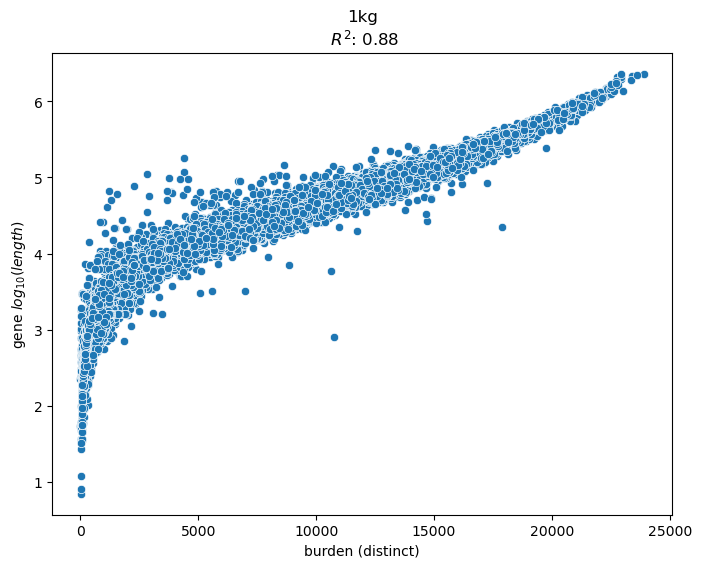

In [148]:
H_burd_distinct_df['len_log'] = H_burd_distinct_df['length'].apply(np.log10)
cor = H_burd_distinct_df['len_log'].corr(H_burd_distinct_df['count'])
r_2 = cor ** 2

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='count', y='len_log', data=H_burd_distinct_df)

# Display the correlation coefficient on the plot
plt.title(f'1kg\n $R^2$: {r_2:.2f}')
plt.xlabel('burden (distinct)')
plt.ylabel('gene $log_{10}(length)$')

# Show the plot
plt.show()

In [102]:
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='count', y='len_log', data=df)

# # Display the correlation coefficient on the plot
# plt.title(f'Scatter Plot len_log and burden\nCorrelation: {correlation:.2f}')
# plt.xlabel('count')
# plt.ylabel('log(length)')
# plt.axvline(x=10000, color='red', linestyle='--' )
# plt.axvline(x=22000, color='red', linestyle='--' )
# plt.axhline(y=2, color='red', linestyle='--' )
# plt.axhline(y=4, color='red', linestyle='--' )

# # Show the plot
# plt.show()

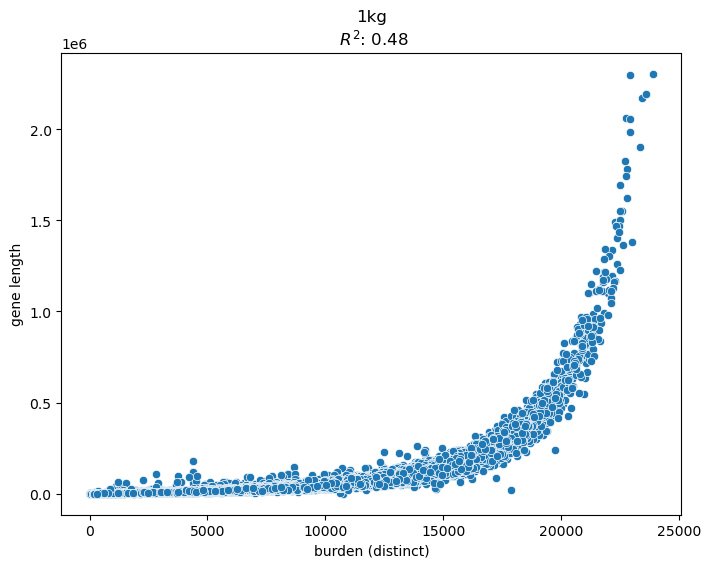

In [147]:
# Create a scatter plot to visualize the correlation
cor = H_burd_distinct_df['length'].corr(H_burd_distinct_df['count'])
r_2 = cor ** 2
plt.figure(figsize=(8, 6))
sns.scatterplot(x='count', y='length', data=H_burd_distinct_df)

# Display the correlation coefficient on the plot
plt.title(f'1kg\n $R^2$: {r_2:.2f}')
plt.xlabel('burden (distinct)')
plt.ylabel('gene length')

# Show the plot
plt.show()

- Gene pair variant burden count has high correlation with the log10 length of the gene (in heatlhy populations)
- Q: what are some of the outliers of this trend?

In [471]:
df_outliers = df[(df['count'] > 10000) & (df['count'] < 22000) & (df['len_log'] > 2) & (df['len_log'] < 4)]
df_outliers

,count,length,len_log,len_sq
CDRT1,10765,793,2.899273,628849
MTnegATP6,15662,680,2.832509,462400
MTnegATP8,10701,206,2.313867,42436
MTnegCO1,18243,1541,3.187803,2374681
MTnegCO2,15511,683,2.834421,466489
MTnegCO3,16637,783,2.893762,613089
MTnegCYB,18622,1140,3.056905,1299600
MTnegND1,17097,955,2.980003,912025
MTnegND2,17354,1041,3.017451,1083681
MTnegND3,12737,345,2.537819,119025


Note: the following outliers have relatively high gene pair variant burden (distinct) compared to other genes with similar lengths
- MT-ND3: mitochondrial genes: https://www.ncbi.nlm.nih.gov/gene/4537
- MT-RNR1: mitochondrial ribosomal RNA: https://www.ncbi.nlm.nih.gov/gene/?term=Mus+musculus+mt-Rnr1
- CDRT1: "F-box" protein, ligase: https://www.ncbi.nlm.nih.gov/gene/374286
    - F-box domain: cell signaling: https://en.wikipedia.org/wiki/F-box_protein
- NGB: neuroglobin https://www.ncbi.nlm.nih.gov/gene/58157
    - highly conserved protein involved in increasing oxgyen uptake in the peripheral and central nervous system

In [479]:
fig = px.scatter(
    df_outliers,
    x="count",
    y="len_log",
    hover_name=df_outliers.index, 
)

fig.write_html(os.path.join(dir_fig, '1kg-burden-distinct-length-outliers.html'))


#### Total
- Gene pair variant burden (total): count the total number of times a source gene has a paired breakpoint variant in a target gene.

In [677]:
def burden_total(gene, row, col):
    return gene, row.sum() + col.sum() - row[gene]

In [678]:
H.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [679]:
H_burden_total = []
for g in H.index:
    H_burden_total.append(burden_total(g, H.loc[g,:], H.loc[:,g]))
df_1kg_burd_tot = pd.DataFrame(H_burden_total, columns=['gene', 'count'])
df_1kg_burd_tot.head()

,gene,count
0,7SK,199
1,A1BG,5431
2,A1BGnegAS1,4443
3,A1CF,36952
4,A2M,21604


In [680]:
df_1kg_burd_tot['log_count'] = df_1kg_burd_tot['count'].apply(np.log10)
df_1kg_burd_tot.head()

,gene,count,log_count
0,7SK,199,2.298853
1,A1BG,5431,3.734880
2,A1BGnegAS1,4443,3.647676
3,A1CF,36952,4.567638
4,A2M,21604,4.334534


Text(0.5, 1.0, '1kg burden total distribution')

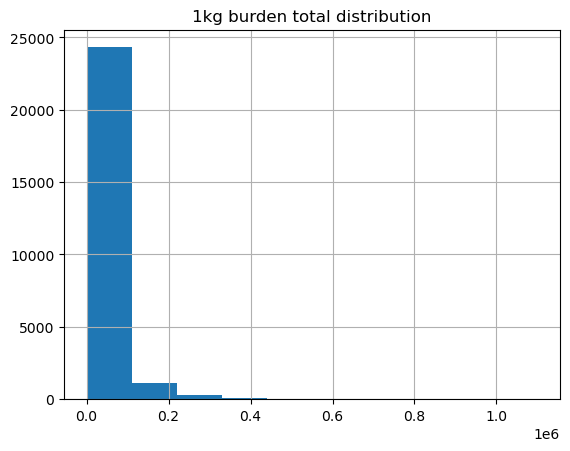

In [683]:
df_1kg_burd_tot['count'].hist()
plt.title('1kg burden total distribution')

Text(0.5, 1.0, 'Log10 1kg burden total distribution')

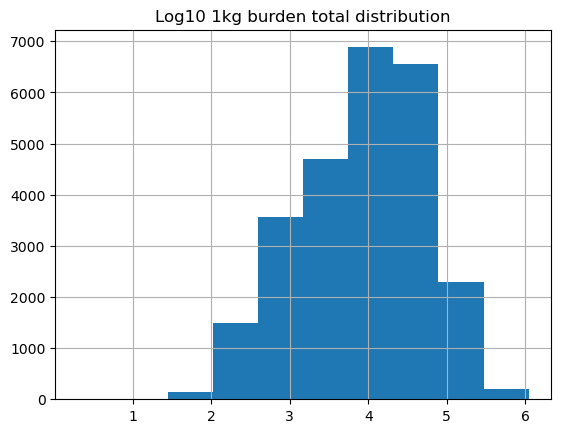

In [684]:
df_1kg_burd_tot['log_count'].hist()
plt.title('Log10 1kg burden total distribution')

In [687]:
def lookup_total(df_burd_tot, gene, log = False):
    if log:
        return df_burd_tot[df_burd_tot['gene'] == gene]['log_count'].values[0]
    else:
        return df_burd_tot[df_burd_tot['gene'] == gene]['count'].values[0]
lookup_total(df_1kg_burd_tot, '7SK')

np.int64(199)

In [486]:
# n targets with position greater than source (source is left interval)
s_row = H.loc['A1BG',:].sum()
# n targets with position less than source (source is right interval)
s_col = H.loc[:,'A1BG'].sum()
s_row + s_col - H.loc['A1BG','A1BG']

np.int64(5446)

In [487]:
# n targets with position greater than source (source is left)
s_row - H.loc['A1BG', 'A1BG']

np.int64(506)

```
(test_venv2) (base) [jakr3437@mcclintock fusions]$ grep -v -w "A1BG" 19.neg.A1BG.58856544.58864865.fusions | wc -l
506
```

In [351]:
def burden_total(gene, row, col):
    return gene, row.sum() + col.sum() - row[gene]
burden_total('A1BG', H.loc['A1BG',:], H.loc[:,'A1BG'])

('A1BG', np.int64(5431))

In [508]:
# new queries use df_1kg_gp_var, not distcint df
queries_total = [(gene, df_1kg_gp_var.loc[gene,:], df_1kg_gp_var.loc[:, gene]) for gene in GENES]
queries_total[1]

('A1BG',
 7SK                   0
 A1BG                194
 A1BGnegAS1          162
 A1CF                  0
 A2M                   0
                    ... 
 ZZZ3                  0
 hsanegmirneg1199      0
 hsanegmirneg150       0
 hsanegmirneg335       0
 hsanegmirneg490       0
 Name: A1BG, Length: 26909, dtype: int64,
 7SK                   0
 A1BG                194
 A1BGnegAS1          146
 A1CF                  1
 A2M                   0
                    ... 
 ZZZ3                  0
 hsanegmirneg1199      0
 hsanegmirneg150       0
 hsanegmirneg335       0
 hsanegmirneg490       0
 Name: A1BG, Length: 26909, dtype: int64)

In [509]:
cpus = 30

with mp.Pool(cpus) as pool:
    #burden_distinct_partial = partial(burden_distinct, df_1kg_gp_var)
    l_burden_total = pool.starmap(burden_total, queries_total)
l_burden_total[0:5]

[('7SK', np.int64(200)),
 ('A1BG', np.int64(5446)),
 ('A1BGnegAS1', np.int64(4458)),
 ('A1CF', np.int64(37089)),
 ('A2M', np.int64(21697))]

In [511]:
df_burden_total = pd.DataFrame(l_burden_total, columns=['gene', 'count'])
df_burden_total.head()

,gene,count
0,7SK,200
1,A1BG,5446
2,A1BGnegAS1,4458
3,A1CF,37089
4,A2M,21697


<Axes: >

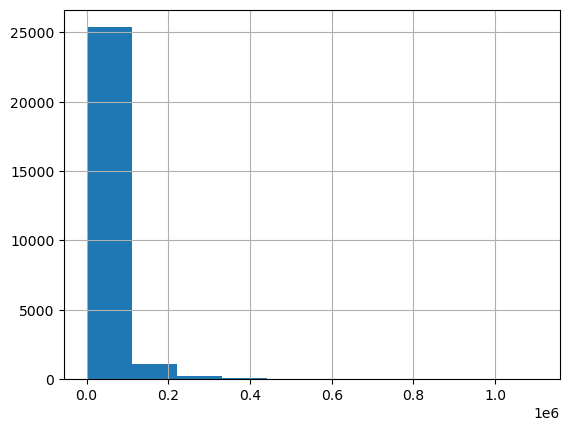

In [512]:
df_burden_total['count'].hist()

In [513]:
df_burden_total['length'] = df_burden_total['gene'].apply(lambda x: gene_location(df_genes, x)[2] - gene_location(df_genes, x)[1])
df_burden_total.head()

,gene,count,length
0,7SK,200,290
1,A1BG,5446,8321
2,A1BGnegAS1,4458,7432
3,A1CF,37089,86266
4,A2M,21697,48565


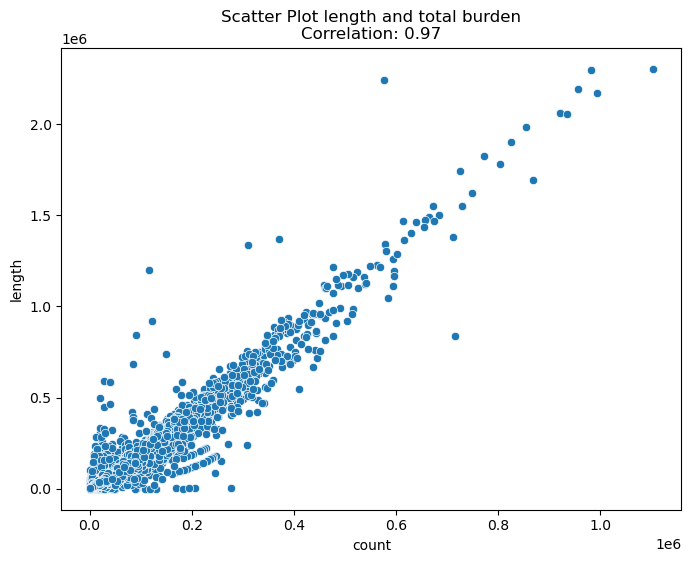

In [518]:
#df_burden_total['l'] = df_burden_total['length'].apply(np.log10)
cor = df_burden_total['length'].corr(df_burden_total['count'])
correlation_btotal = df_burden_total['length'].corr(df_burden_total['count'])

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='count', y='length', data=df_burden_total)

# Display the correlation coefficient on the plot
plt.title(f'Scatter Plot length and total burden\nCorrelation: {correlation_btotal:.2f}')
plt.xlabel('count')
plt.ylabel('length')

# Show the plot
plt.show()

- Count and length ranges are now similar. And, the relationship is linear.

In [75]:
# fusion common in healthy population
df_1kg_gp_var.loc['GPR128', 'TFG']
df_1kg_gp_var.loc['TFG', 'GPR128']

np.int64(122)

### Top K

In [233]:
H.index[0]

'7SK'

In [234]:
H_no_diag = H.copy()
for g in H_no_diag.index:
    H_no_diag.loc[g,g] = 0
H_no_diag.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,0,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [235]:
cpus=64
def compute_max_row_H(i):
    return H_no_diag.index[i], H_no_diag.iloc[i,:].max(), H_no_diag.iloc[i,:].idxmax()
compute_max_row_H(0)
with mp.Pool(cpus) as pool:
    H_max_rows = pool.map(compute_max_row_H, range(H_no_diag.shape[0]))
H_max_rows[0:5]
    

[('7SK', np.int64(6), 'RP11neg661A12.5'),
 ('A1BG', np.int64(162), 'A1BGnegAS1'),
 ('A1BGnegAS1', np.int64(146), 'A1BG'),
 ('A1CF', np.int64(283), 'ASAH2B'),
 ('A2M', np.int64(32), 'MACROD2')]

In [238]:
H_max_target = pd.DataFrame(H_max_rows, columns=['source','count', 'target']).sort_values('count', ascending=False)
H_max_target.to_csv('/data/jake/genefusion/data/1kg-max_targets.tsv', sep='\t')

In [229]:
H_no_diag.loc['PTPRN2', 'PTPRN2']

np.int64(151499)

In [237]:
H_max_target.head(50)

,source,count,target
22961,TBC1D3,36268,RP11neg1407O15.2
1173,ACOT13,24744,SYN3
19598,RP11neg745O10.2,19636,TMBIM4
2251,ARHGAP19negSLIT1,19615,ARHGAP19
2250,ARHGAP19,19590,ARHGAP19negSLIT1
23070,TDG,17925,TMEM132B
1309,ADAP1,17880,COX19
5070,COX19,17858,ADAP1
2736,BAZ2A,17688,FSIP1
13676,NOTCH2,17622,RP11neg458D21.5


- Most of these are neighboring genes

Text(0.5, 0, 'count')

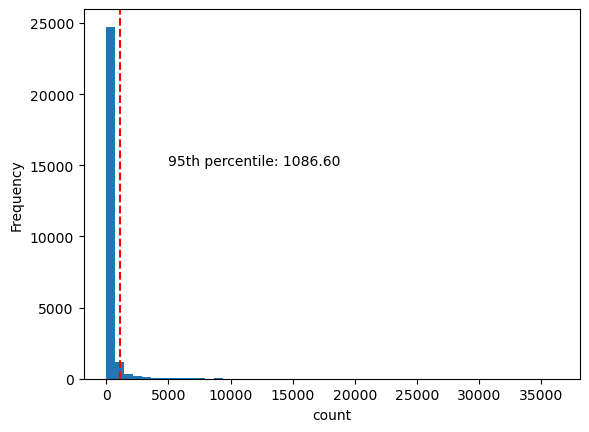

In [108]:
max_target_per_gene_1kg['count'].plot(kind='hist', bins=50)
q = max_target_per_gene_1kg['count'].quantile(0.95)
plt.axvline(x=q, color='red', linestyle='--')
plt.text(5000,15000, f'95th percentile: {q:.2f}')
plt.xlabel('count')

## PCAWG

In [197]:
dir_pcawg = '/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/fusions2'
fusionfiles_pcawg = glob.glob(os.path.join(dir_pcawg, '*.fusions'))

In [198]:
fusionfiles_pcawg[0:5]

['/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/fusions2/1.neg.ZNF669.247263264.247267674.fusions',
 '/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/fusions2/17.neg.CCL3.34415602.34417515.fusions',
 '/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/fusions2/20.pos.VAPB.56964178.57026157.fusions',
 '/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/fusions2/10.pos.RP11neg162G10.5.38146668.38148038.fusions',
 '/data/jake/genefusion/data/2024_11_10-fusions-pcawg-combined/fusions2/11.neg.RP5neg901A4.1.67792277.67797928.fusions']

In [199]:
# ignore empty files (if they exist)
print(len(fusionfiles_pcawg))
fusionfiles_pcawg_not_empty = [f for f in fusionfiles_pcawg if os.stat(f).st_size > 0]
print(len(fusionfiles_pcawg_not_empty))



26954
26949


In [200]:
cpus=64
with mp.Pool(processes=cpus) as pool:
    gene_var_pairs_pcawg = pool.map(count_gene_var_pairs, fusionfiles_pcawg_not_empty)

In [201]:
gene_var_pairs_pcawg[0]

ZNF669
ZNF669      3593
UNK          433
DPP6          89
ARID2         88
MUC13         83
            ... 
IL13RA2        1
LUZP4          1
AKAP14         1
KIAA1462       1
RNF128         1
Name: ZNF669, Length: 5417, dtype: int64

In [203]:
def compute_row(gene_var_pairs_ser):
    blank = pd.Series(0, index=GENES, dtype=np.int64)
    for target, count in gene_var_pairs_ser.items():
        blank.loc[target] += count
    blank.name = gene_var_pairs_ser.name
    return blank
compute_row(gene_var_pairs_pcawg[0])
# print(gene_var_pairs_pcawg[0].name)
# C.loc['ZNF669', :]

7SK                 0
A1BG                0
A1BGnegAS1          0
A1CF                1
A2M                 0
                   ..
ZZZ3                0
hsanegmirneg1199    0
hsanegmirneg150     0
hsanegmirneg335     0
hsanegmirneg490     2
Name: ZNF669, Length: 26871, dtype: int64

In [204]:
cpus=64
with mp.Pool(cpus) as pool:
    results = pool.map(compute_row, gene_var_pairs_pcawg)
C = pd.DataFrame(results)
C.sort_index(inplace=True)
# combine result of duplicate gene names
C = C.groupby(C.index).sum()
C.to_csv('/data/jake/genefusion/data/pcawg-gene_var_pairs.tsv',sep='\t')


In [205]:
C.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,6018,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3885,5197,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,2,2,76450,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,93
A2M,0,0,1,0,40139,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,35


In [68]:
C = C.groupby(C.index).sum()
npz_path_pcawg = '/data/jake/genefusion/data/pcawg-gene_var_pairs.npz'
np.savez_compressed(npz_path_pcawg, data = C.to_numpy(), columns=C.columns.to_numpy(), index=C.index.to_numpy())

In [67]:
loaded = np.load(npz_path_pcawg, allow_pickle=True)
C = pd.DataFrame(
    loaded["data"],
    columns=loaded["columns"],
    index=loaded["index"]
)
del loaded

In [39]:
# do numpy format
# do burden
# do burden cor length
# do subtraction
# do robust scalar and subtraction
# do min max scale and subtraction

### Burden

#### Distinct

In [112]:
cpus=64
chunks = np.array_split(C, cpus)
with mp.Pool(cpus) as pool:
    results = pool.map(process_chunk, chunks)
C_distinct = pd.concat(results)
del chunks
del results
C_distinct.head()

/data/jake/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
A1BGnegAS1,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
A1CF,0,1,1,1,1,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,1
A2M,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1


In [113]:
npz_path_pcawg = '/data/jake/genefusion/data/pcawg-gene_var_pairs_distinct.npz'
np.savez_compressed(npz_path_pcawg, data = C_distinct.to_numpy(), columns=C_distinct.columns.to_numpy(), index=C_distinct.index.to_numpy())

In [114]:
# make sure to only loop row idx since some genes are excluded if empty
# columns contain all possible genes
queries_C_d = []
for g in C_distinct.index:
    # gene, row, col
    queries_C_d.append((g, C_distinct.loc[g,:], C_distinct.loc[:, g]))
queries_C_d[1]

('A1BG',
 7SK                 0
 A1BG                1
 A1BGnegAS1          1
 A1CF                0
 A2M                 0
                    ..
 ZZZ3                0
 hsanegmirneg1199    0
 hsanegmirneg150     0
 hsanegmirneg335     0
 hsanegmirneg490     1
 Name: A1BG, Length: 26871, dtype: int64,
 7SK                 0
 A1BG                1
 A1BGnegAS1          1
 A1CF                1
 A2M                 0
                    ..
 ZZZ3                1
 hsanegmirneg1199    1
 hsanegmirneg150     0
 hsanegmirneg335     0
 hsanegmirneg490     0
 Name: A1BG, Length: 26866, dtype: int64)

In [117]:
C_burd_distinct = {}
for i,x in enumerate(queries_C_d):
    gene, ser_row, ser_col = x
    print(i,gene)
    C_burd_distinct[gene] = burden_distinct(gene, ser_row, ser_col)

0 7SK
1 A1BG
2 A1BGnegAS1
3 A1CF
4 A2M
5 A2ML1
6 A2ML1negAS1
7 A2ML1negAS2
8 A2MnegAS1
9 A3GALT2
10 A4GALT
11 A4GNT
12 AAAS
13 AACS
14 AADAC
15 AADACL2
16 AADACL3
17 AADACL4
18 AADAT
19 AAED1
20 AAGAB
21 AAK1
22 AAMDC
23 AAMP
24 AANAT
25 AAR2
26 AARD
27 AARS
28 AARS2
29 AARSD1
30 AASDH
31 AASDHPPT
32 AASS
33 AATF
34 AATK
35 AATKnegAS1
36 ABAT
37 ABCA1
38 ABCA10
39 ABCA12
40 ABCA13
41 ABCA2
42 ABCA3
43 ABCA4
44 ABCA5
45 ABCA6
46 ABCA7
47 ABCA8
48 ABCA9
49 ABCA9negAS1
50 ABCB1
51 ABCB10
52 ABCB11
53 ABCB4
54 ABCB5
55 ABCB6
56 ABCB7
57 ABCB8
58 ABCB9
59 ABCC1
60 ABCC10
61 ABCC11
62 ABCC12
63 ABCC2
64 ABCC3
65 ABCC4
66 ABCC5
67 ABCC5negAS1
68 ABCC6
69 ABCC8
70 ABCC9
71 ABCD1
72 ABCD2
73 ABCD3
74 ABCD4
75 ABCE1
76 ABCF1
77 ABCF2
78 ABCF3
79 ABCG1
80 ABCG2
81 ABCG4
82 ABCG5
83 ABCG8
84 ABHD1
85 ABHD10
86 ABHD11
87 ABHD12
88 ABHD12B
89 ABHD13
90 ABHD14A
91 ABHD14AnegACY1
92 ABHD14B
93 ABHD15
94 ABHD16A
95 ABHD16B
96 ABHD17A
97 ABHD17B
98 ABHD17C
99 ABHD2
100 ABHD3
101 ABHD4
102 ABHD5
103 ABHD

In [ ]:
mask_erg = H_burd_distinct_ser.index.str.contains('^ERG$')
mask_tmprss2 = H_burd_distinct_ser.index.str.contains('^TMPRSS2$')
a = H_burd_distinct_ser[mask_erg]
b = H_burd_distinct_ser[mask_tmprss2]
print(a,b)

ERG    29144
dtype: int64 TMPRSS2    23870
dtype: int64


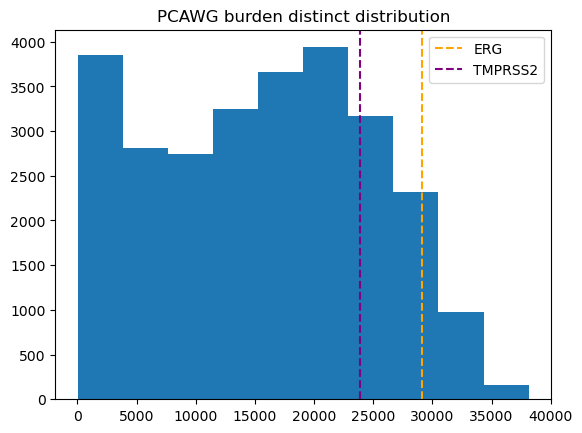

In [150]:
C_burd_distinct_ser = pd.Series(C_burd_distinct)
C_burd_distinct_ser.hist()

mask_erg = C_burd_distinct_ser.index.str.contains('^ERG$')
mask_tmprss2 = C_burd_distinct_ser.index.str.contains('^TMPRSS2$')
a = C_burd_distinct_ser[mask_erg]
b = C_burd_distinct_ser[mask_tmprss2]

print(a,b)
plt.title('PCAWG burden distinct distribution')
plt.axvline(x=a.values, color='orange', linestyle='--')
plt.axvline(x=b.values, color='purple', linestyle='--')
plt.legend(['ERG', 'TMPRSS2'])
plt.grid(False)

In [121]:
C_burd_distinct_df = C_burd_distinct_ser.to_frame()
C_burd_distinct_df.columns = ['count']
C_burd_distinct_df['length'] = C_burd_distinct_df.index.map(lambda x: gene_location(df_genes, x)[2] - gene_location(df_genes, x)[1])
C_burd_distinct_df.head()


,count,length
7SK,647,290
A1BG,14354,8321
A1BGnegAS1,13716,7432
A1CF,23316,86266
A2M,19925,48565


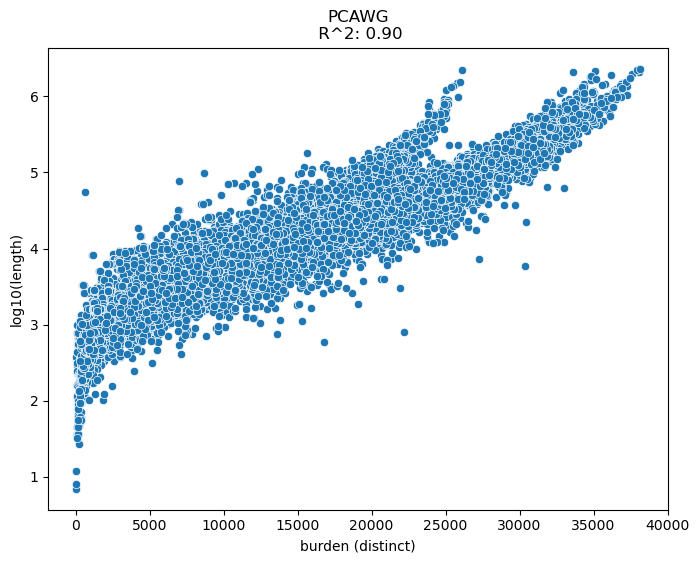

In [733]:
C_burd_distinct_df['len_log'] = C_burd_distinct_df['length'].apply(np.log10)
cor = C_burd_distinct_df['len_log'].corr(C_burd_distinct_df['count'])
r_2 = cor ** 2

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='count', y='len_log', data=C_burd_distinct_df)

# Display the correlation coefficient on the plot
plt.title(f'PCAWG\n R^2: {r_2:.2f}')
plt.xlabel('burden (distinct)')
plt.ylabel('log10(length)')

# Show the plot
plt.show()

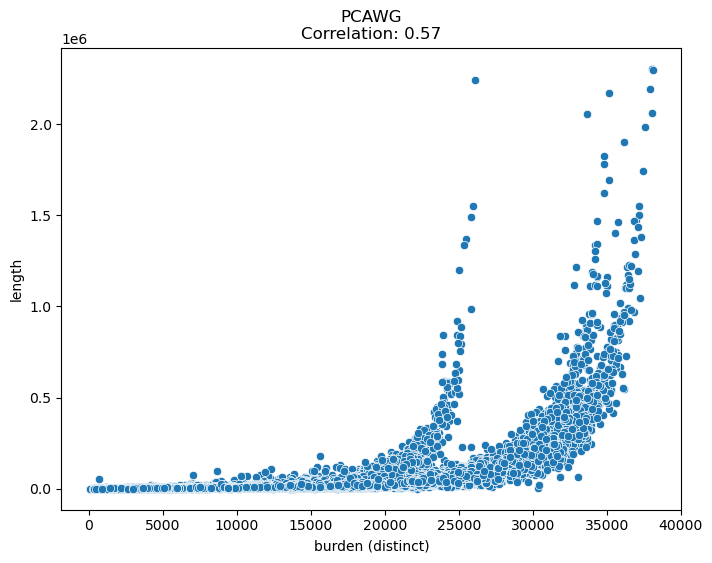

In [125]:
correlation = C_burd_distinct_df['length'].corr(C_burd_distinct_df['count'])
# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='count', y='length', data=C_burd_distinct_df)

# Display the correlation coefficient on the plot
plt.title(f'PCAWG\nCorrelation: {correlation:.2f}')
plt.xlabel('burden (distinct)')
plt.ylabel('length')

# Show the plot
plt.show()

#### Total

In [392]:
#burden_total('A1BG', H.loc['A1BG',:], H.loc[:,'A1BG'])
print(burden_total('LRRC4C', H.loc['LRRC4C',:], H.loc[:,'LRRC4C']),
burden_total('LRRC4C', C.loc['LRRC4C',:], C.loc[:,'LRRC4C'])
)
print(burden_total('ERG', H.loc['ERG',:], H.loc[:,'ERG']),
burden_total('ERG', C.loc['ERG',:], C.loc[:,'ERG'])
)
#queries_total = [(gene, df_1kg_gp_var.loc[gene,:], df_1kg_gp_var.loc[:, gene]) for gene in GENES]

('LRRC4C', np.int64(576397)) ('LRRC4C', np.int64(25911537))
('ERG', np.int64(134418)) ('ERG', np.int64(1530025))


In [393]:
burden_total('ERG', C.loc['ERG',:], C.loc[:,'ERG'])

('ERG', np.int64(1530025))

In [ ]:
C_burden_total = []
for g in C.index:
    C_burden_total.append(burden_total(g, C.loc[g,:], C.loc[:,g]))
df_pcawg_burd_tot = pd.DataFrame(C_burden_total, columns=['gene', 'count'])
df_pcawg_burd_tot.head()

6.184698527074687 5.590588849753433


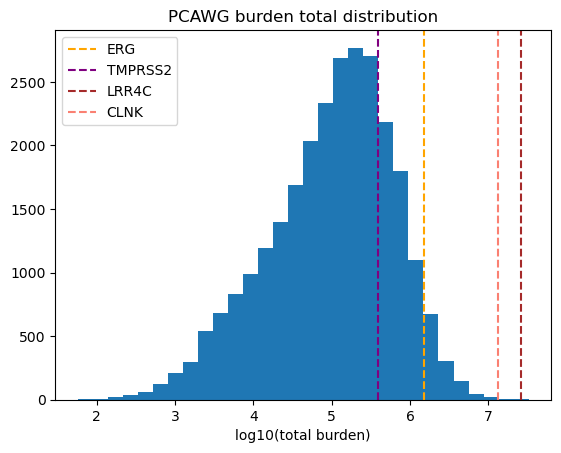

In [417]:
df_pcawg_burd_tot['log_count'] = df_pcawg_burd_tot['count'].apply(np.log10)
df_pcawg_burd_tot['log_count'].hist(bins=30)
mu_tot_pcawg = df_pcawg_burd_tot['count'].mean()
sigma_tot_pcawg = df_pcawg_burd_tot['count'].std()
mu_tot_pcawg_log = df_pcawg_burd_tot['log_count'].mean()
sigma_tot_pcawg_log = df_pcawg_burd_tot['log_count'].std()

erg_mask = df_pcawg_burd_tot['gene'] == 'ERG'
tmprss2_mask = df_pcawg_burd_tot['gene'] == 'TMPRSS2'
lrrc4c_mask = df_pcawg_burd_tot['gene'] == 'LRRC4C'
clnk_mask = df_pcawg_burd_tot['gene'] == 'CLNK'
a = df_pcawg_burd_tot[erg_mask].iloc[0,2]
b= df_pcawg_burd_tot[tmprss2_mask].iloc[0,2]
c = df_pcawg_burd_tot[lrrc4c_mask].iloc[0,2]
d= df_pcawg_burd_tot[clnk_mask].iloc[0,2]

print(a,b)
plt.title('PCAWG burden total distribution')
plt.axvline(x=a, color='orange', linestyle='--')
plt.axvline(x=b, color='purple', linestyle='--')
plt.axvline(x=c, color='brown', linestyle='--')
plt.axvline(x=d, color='salmon', linestyle='--')
plt.xlabel('log10(total burden)')
plt.legend(['ERG', 'TMPRSS2', 'LRR4C', 'CLNK'])
plt.grid(False)

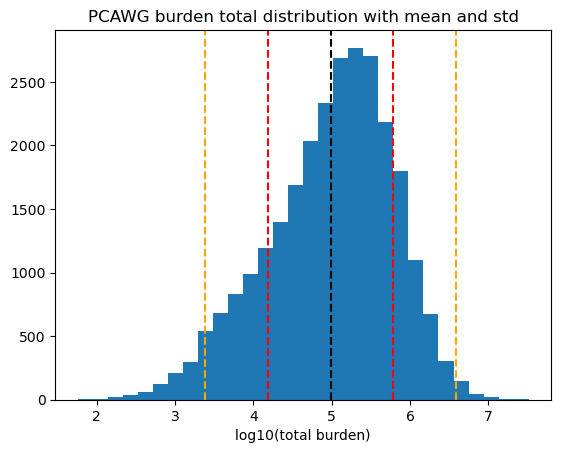

In [418]:
df_pcawg_burd_tot['log_count'].hist(bins=30)
plt.axvline(x=mu_tot_pcawg_log, color='black', linestyle='--')
plt.axvline(x=mu_tot_pcawg_log+sigma_tot_pcawg_log, color='red', linestyle='--')
plt.axvline(x=mu_tot_pcawg_log-sigma_tot_pcawg_log, color='red', linestyle='--')
plt.axvline(x=mu_tot_pcawg_log+(2*sigma_tot_pcawg_log), color='orange', linestyle='--')
plt.axvline(x=mu_tot_pcawg_log-(2*sigma_tot_pcawg_log), color='orange', linestyle='--')
plt.title("PCAWG burden total distribution with mean and std")
plt.xlabel('log10(total burden)')
plt.grid(False)

### Validation

In [152]:
C_no_diag = C.copy()
for g in C_no_diag.index:
    C_no_diag.loc[g,g] = 0
C_no_diag.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3885,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,2,2,0,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,93
A2M,0,0,1,0,0,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,35


In [153]:
def validate_n_rank(arr, source, target, k=10):
    print(f'#{source}-{target}', arr.loc[source, target])
    print(arr.loc[source,:].nlargest(k))
validate_n_rank(C_no_diag, 'ERG', 'TMPRSS2', k=10)
    

#ERG-TMPRSS2 5694
TMPRSS2    5694
EPHB1      3773
DMD        2608
PHF2       2007
GLRA2      1993
NPC1L1     1937
PTPRD      1373
CNTNAP2    1282
CEP72      1246
CSMD1      1243
Name: ERG, dtype: int64


In [154]:
validate_n_rank(C_no_diag, 'ETV1', 'TMPRSS2', k=10)

#ETV1-TMPRSS2 80
HDAC9      2916
TJP2       1006
CSMD1       824
MSRA        784
PTPRD       733
CNTNAP2     708
DMD         527
MAGI2       468
AUTS2       350
TRPM3       340
Name: ETV1, dtype: int64


In [155]:
validate_n_rank(C_no_diag, 'ETV4', 'TMPRSS2', k=10)

#ETV4-TMPRSS2 15
RP11neg392O1.4    25370
DHX8              11629
PTPRD               564
ZNF765              334
RFX2                333
NOL4                327
HPGDS               325
DMD                 306
RUNX1               306
PDE4D               282
Name: ETV4, dtype: int64


In [160]:
validate_n_rank(C_no_diag, 'ETV5', 'TMPRSS2', k=10)

#ETV5-TMPRSS2 3
DGKG          3980
ETV5negAS1    1563
CNTNAP2        460
CSMD1          414
PTPRD          414
DMD            347
EYS            286
PARK2          286
ABCA13         278
AUTS2          275
Name: ETV5, dtype: int64


## Subtraction

### Fix shapes

In [168]:
print(C.shape)
C.head()

(26866, 26871)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,6018,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3885,5197,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,2,2,76450,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,93
A2M,0,0,1,0,40139,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,35


In [169]:
print(H.shape)
H.head()

(25842, 26871)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


Pad rows: some genes in PCAWG had non-empty fusion files compared to 1kg

In [170]:
i = 0
gene_pad_1kg = []
for g_c in C.index:
    if not g_c in H.index:
        i += 1
        print(g_c)
        gene_pad_1kg.append(g_c)
print(i)

ABCB7
ABCD1
AC002365.1
AC002368.4
AC006156.1
AC007965.1
AC009977.1
AC010877.1
AC012067.1
AC016752.1
AC115618.1
ACE2
ACOT9
ACRC
ACSL4
ACTRT1
AF196779.12
AF196970.3
AF196972.9
AFF2
AFF2negIT1
AGTR2
AIFM1
AKAP14
AKAP17A
AKAP4
AL353698.1
ALAS2
ALG13
ALG13negAS1
AMELX
AMELY
AMER1
AMMECR1
AMMECR1negIT1
AMOT
AP1S2
APEX2
APLN
APOO
APOOL
AR
ARAF
ARHGAP36
ARHGAP4
ARHGAP6
ARHGEF6
ARHGEF9
ARHGEF9negIT1
ARL13A
ARMCX1
ARMCX2
ARMCX3
ARMCX3negAS1
ARMCX4
ARMCX5
ARMCX6
ARR3
ARSD
ARSDnegAS1
ARSE
ARSF
ARSH
ARX
ASB11
ASB12
ASB9
ASMT
ASMTL
ASMTLnegAS1
ATG4A
ATP11C
ATP1B4
ATP2B3
ATP6AP1
ATP6AP2
ATP7A
ATRX
ATXN3L
AVPR2
AWAT1
AWAT2
BCAP31
BCOR
BCORL1
BEND2
BEX1
BEX2
BEX4
BEX5
BGN
BHLHB9
BMP15
BMX
BPY2
BPY2B
BPY2C
BRCC3
BRS3
BRWD3
BTK
C1GALT1C1
CA5B
CACNA1F
CAPN6
CASK
CASKnegAS1
CCDC120
CCDC160
CCDC22
CCNB3
CD40LG
CD99
CD99L2
CDK16
CDKL5
CDR1
CDX4
CDY1B
CDY2A
CDY2B
CENPI
CETN2
CFP
CHDC2
CHIC1
CHM
CHRDL1
CHST7
CITED1
CLCN4
CLCN5
CLDN2
CLIC2
CMC4
CNGA2
CNKSR2
COL4A5
COL4A6
COX7B
CPXCR1
CRLF2
CSAG1
CSAG2
CSAG3
CSF

In [171]:
i = 0
for g_h in H.index:
    if not g_h in C.index:
        i += 1
        print(g_h)
        
print(i)

0


In [172]:
H_pad = pd.DataFrame(0, index=gene_pad_1kg, columns=GENES)
print(H_pad.shape)
H_pad.head()

(1024, 26871)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
ABCB7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC002365.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC002368.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC006156.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
H_padded = pd.concat([H, H_pad], axis=0)
H_padded.sort_index(inplace=True)
print(H_padded.shape)
H_padded.head()

(26866, 26871)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,194,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,221,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,1459,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,860,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


### No norm

In [174]:
C

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,6018,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3885,5197,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,2,2,76450,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,93
A2M,0,0,1,0,40139,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZ3,0,3,1,36,15,34,23,0,0,0,...,20,0,0,7,74,101384,2,0,2,178
hsanegmirneg1199,0,3,3,0,0,0,0,0,0,0,...,2,0,0,1,0,0,1256,0,0,0
hsanegmirneg150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,246,0,1
hsanegmirneg335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2184,1


In [428]:
C_no_diag = C.copy()
for g in C_no_diag.index:
    C_no_diag.loc[g,g] = 0
C_no_diag.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3885,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,2,2,0,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,93
A2M,0,0,1,0,0,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,35


In [176]:
H_padded_no_diag = H_padded.copy()
for g in H_padded_no_diag.index:
    H_padded_no_diag.loc[g,g] = 0
H_padded_no_diag.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,162,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,0,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [178]:
X = C_no_diag - H_padded_no_diag
X.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,4461,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3739,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,93
A2M,0,0,1,0,0,0,0,0,61,0,...,1,0,0,0,15,0,0,0,0,35


In [ ]:
X.to_csv('/data/jake/genefusion/data/pcawg-1kg-gene_var_pairs_diff.tsv',sep='\t')

In [179]:
X.loc['ERG', 'TMPRSS2']

np.int64(5686)

In [606]:
flattened = X.to_numpy().flatten()
top_10_indices = np.argpartition(flattened, -10)[-10:]
top_10_values = flattened[top_10_indices]
top_10_sorted = np.sort(top_10_values)[::-1]

print("Top 10 largest values:", top_10_sorted)

# If you need the original 2D coordinates
original_coords = np.unravel_index(top_10_indices, X.shape)
def topk_df(d, k=10):
    flattened = d.to_numpy().flatten()
    top_10_indices = np.argpartition(flattened, -10)[-10:]
    top_10_values = flattened[top_10_indices]
    top_10_sorted = np.sort(top_10_values)[::-1]
    original_coords = np.unravel_index(top_10_indices, d.shape)
    r_idx = np.unravel_index(top_10_indices, d.shape)[0]
    c_idx = np.unravel_index(top_10_indices, d.shape)[1]
    topk = {'g_i': [], 'g_j': [], 'count': []}
    for i,j in zip(r_idx, c_idx):
        topk['g_i'].append(d.index[i])
        topk['g_j'].append(d.columns[j])
        topk['count'].append(d.iloc[i,j])
    return topk

Top 10 largest values: [26816814  7977624  6185105  6110596  5305503  4921690  4845359  4405992
  3398610  3055754]


In [181]:
r_idx = np.unravel_index(top_10_indices, X.shape)[0]
c_idx = np.unravel_index(top_10_indices, X.shape)[1]

In [182]:
for i,j in zip(r_idx, c_idx):
    print(X.index[i], X.columns[j], X.iloc[i,j])

VAV3 EFCAB2 3055754
CHAT AVL9 3398610
VAV3 CHAT 4405992
VAV3 AVL9 4845359
CROCC LRRC4C 4921690
LRRC4C SLC9A7 5305503
ANO5 DCDC1 6110596
CA8 MCTS1 6185105
LRRC4C CLNK 7977624
PCDH9 ARSF 26816814


In [184]:
print(
    H_padded_no_diag.loc['VAV3', 'EFCAB2'],
    H_padded_no_diag.loc['CHAT', 'AVL9'],
    H_padded_no_diag.loc['VAV3', 'CHAT'],
    H_padded_no_diag.loc['VAV3', 'AVL9'],
)

19 0 16 105


### Rule 1

- Ignore all gene pairs with >= 10 evidence in 1kg

In [233]:
def fill_high(series, high = 10 ** 12):
    return series.apply(lambda x: high if x >=10 else x)
print(H_padded_no_diag.loc['VAV3'].apply(lambda x: np.inf if x >=10 else x).head())
print(fill_high(H_padded_no_diag.loc['VAV3']).head())

7SK           0.0
A1BG          1.0
A1BGnegAS1    0.0
A1CF          inf
A2M           inf
Name: VAV3, dtype: float64
7SK                       0
A1BG                      1
A1BGnegAS1                0
A1CF          1000000000000
A2M           1000000000000
Name: VAV3, dtype: int64


In [234]:
# use generator to avoid writing storing each series in mem
g = (b for _,b in H_padded_no_diag.iterrows())
cpus=64
with mp.Pool(cpus) as pool:
    results = pool.map(fill_high, g)
H_padded_no_diag_geq10_high = pd.DataFrame(results)
H_padded_no_diag_geq10_high.sort_index(inplace=True)
del results
H_padded_no_diag_geq10_high.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,1000000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BGnegAS1,0,1000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,1,1,0,2,1,1,0,0,0,...,0,0,0,0,4,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0


In [624]:
X_rule1 = C_no_diag - H_padded_no_diag_geq10_high
X_rule1.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,-999999995377,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,-999999996115,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,93
A2M,0,0,1,0,0,0,0,0,61,0,...,1,0,0,0,15,0,0,0,0,35


In [239]:
topk_df(X_geq10_high)

UBXN11 MCTS1 977866
CROCC SLC9A7 1371969
UBXN11 C12orf55 1510210
CLNK SLC9A7 1853580
UBXN11 CA8 2024719
EFCAB2 CHAT 2229651
CHAT AVL9 3398610
LRRC4C SLC9A7 5305503
CA8 MCTS1 6185105
LRRC4C CLNK 7977624


### Rule 2

- Filter C burden total
- Plus rule 1

Rules
- $bt(i,j) < \mu_{bt_{C}} + 2\sigma_{bt_{C}}$
- $H[i,j] \leq 10$

In [413]:
burden_total('ERG', C.loc['ERG',:], C.loc[:,'ERG'])

('ERG', np.int64(1530025))

In [425]:
mu_tot_pcawg + (2*sigma_tot_pcawg)

np.float64(1852434.3742822474)

In [429]:
C_no_diag.loc['ERG', :]

7SK                   0
A1BG                  0
A1BGnegAS1            0
A1CF                  0
A2M                   0
                   ... 
ZZZ3                  0
hsanegmirneg1199      0
hsanegmirneg150       0
hsanegmirneg335       0
hsanegmirneg490     225
Name: ERG, Length: 26871, dtype: int64

In [446]:
mu = mu_tot_pcawg
sigma = sigma_tot_pcawg
def rule_filt_C_bt(gene, mu, sigma):
    _, b_g = burden_total(gene, C.loc[gene,:], C.loc[:,gene])
    if (b_g > (mu + (2*sigma))):
        return False
    else:
        return True
C_bt_filt = C_no_diag.copy()
for i in C_bt_filt.index:
    c = rule_filt_C_bt(i, mu, sigma)
    if not c:
        C_bt_filt.loc[i,:] = -(10 ** 12)
        C_bt_filt.loc[:,i] = -(10 ** 12)
C_bt_filt.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1000000000000
A1BG,0,0,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,-1000000000000
A1BGnegAS1,0,3885,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1000000000000
A1CF,0,2,2,0,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,-1000000000000
A2M,0,0,1,0,0,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,-1000000000000


In [454]:
print(
C_bt_filt.loc['CLNK', :].head(),
C_bt_filt.loc[:, 'CLNK'].head(),'\n\n',
C_bt_filt.loc['ERG', :].head(),
C_bt_filt.loc[:, 'ERG'].head()
)

7SK          -1000000000000
A1BG         -1000000000000
A1BGnegAS1   -1000000000000
A1CF         -1000000000000
A2M          -1000000000000
Name: CLNK, dtype: int64 7SK          -1000000000000
A1BG         -1000000000000
A1BGnegAS1   -1000000000000
A1CF         -1000000000000
A2M          -1000000000000
Name: CLNK, dtype: int64 

 7SK           0
A1BG          0
A1BGnegAS1    0
A1CF          0
A2M           0
Name: ERG, dtype: int64 7SK            0
A1BG           1
A1BGnegAS1     5
A1CF          44
A2M           65
Name: ERG, dtype: int64


In [642]:
X_rule2 = C_bt_filt - H_padded_no_diag_geq10_high
X_rule2.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1000000000000
A1BG,0,0,-999999995377,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,-1000000000000
A1BGnegAS1,0,-999999996115,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1000000000000
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,-1000000000000
A2M,0,0,1,0,0,0,0,0,61,0,...,1,0,0,0,15,0,0,0,0,-1000000000000


In [456]:
topk_df(X_bt_filt_get10_high)

NFE2L2 RASSF6 35578
RP11neg712L6.5 RP11neg44K6.3 37857
TIRAP RP11neg44K6.3 37857
TIRAP IDO2 37860
RP11neg712L6.5 IDO2 37860
RAPGEFL1 RP11neg188C12.3 38758
TMLHE TMLHEnegAS1 44346
TMLHEnegAS1 TMLHE 44646
ONECUT2 SCN5A 59707
TSSC1 SNX16 167850


In [ ]:
g = ((row, mu_tot_pcawg, sigma_tot_pcawg) for _,row in C_no_diag.iterrows())
with mp.Pool(cpus) as pool:
    C_filt_bt_rows = pool.starmap(rule_filt_C_bt, g)
C_filt_bt = pd.DataFrame(C_filt_bt_rows)
C_filt_bt.sort_index(inplace=True)
del C_filt_bt_rows
C_filt_bt.head()

### Rule 3

- $C[i,j] = - (10^{12}) \text{ if } d(i,j) = 1$

In [509]:
df_genes.head()

,chrm,start,end,gene,strand
0,1,69091,70008,OR4F5,pos
1,1,134901,139379,AL627309.1,neg
2,1,139790,140339,RP11neg34P13.14,neg
3,1,367640,368634,OR4F29,pos
4,1,621059,622053,OR4F16,neg


In [510]:
gene_location(df_genes, 'ERG')

('21', np.int64(39751949), np.int64(40033704))

In [576]:
def gene_neigbors(gene, df_genes, d=1):
    # c: current
    # p: previous
    # n: next
    l = df_genes.shape[0]
    mask = df_genes['gene'] == gene
    c = df_genes[mask].index[0]
    chrm_c = df_genes.loc[c, 'chrm']
    # print(d_i)
    p = c - d
    n = c + d
    # initial
    g_p = None
    g_n = None
    # ensure same chromosome
    if (p>=0): # handle first gene
        chrm_p = df_genes.loc[p, 'chrm']
        if (chrm_p == chrm_c):
            g_p = df_genes.loc[p, 'gene']
            # print(g_p)
            # prev.append(g_p)
    if (n < l): # handle last gene
        chrm_n = df_genes.loc[n, 'chrm']
        if (chrm_n == chrm_c):
            g_n = df_genes.loc[n, 'gene']
            # print(g_n)
            # nex.append(g_n)
    return g_p, g_n
    # return list(zip(prev, nex))
gene_neigbors('ERG', df_genes)

('KCNJ15', 'ETS2')

In [577]:
C_no_diag.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,4623,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3885,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,2,2,0,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,93
A2M,0,0,1,0,0,0,0,0,62,0,...,1,0,0,0,17,0,0,0,0,35


In [586]:
# rule 3: neighbors get penalized in C
C_no_diag_bt_filt_no_nbs = C_bt_filt.copy()
fill = np.int64(- (10 ** 12))
# i = 0
for g in C_no_diag_bt_filt_no_nbs.index:
    # d = 1
    g_p, g_n = gene_neigbors(g, df_genes)
    if g_p:
        if g_p in C_no_diag_bt_filt_no_nbs.index:
            C_no_diag_bt_filt_no_nbs.loc[g,g_p] = fill
            C_no_diag_bt_filt_no_nbs.loc[g_p,g] = fill
    if g_n:
        if g_n in C_no_diag_bt_filt_no_nbs.index:
            C_no_diag_bt_filt_no_nbs.loc[g,g_n] = fill
            C_no_diag_bt_filt_no_nbs.loc[g_n,g] = fill
    # d = 2
    g_p, g_n = gene_neigbors(g, df_genes,d=2)
    if g_p:
        if g_p in C_no_diag_bt_filt_no_nbs.index:
            C_no_diag_bt_filt_no_nbs.loc[g,g_p] = fill
            C_no_diag_bt_filt_no_nbs.loc[g_p,g] = fill
    if g_n:
        if g_n in C_no_diag_bt_filt_no_nbs.index:
            C_no_diag_bt_filt_no_nbs.loc[g,g_n] = fill
            C_no_diag_bt_filt_no_nbs.loc[g_n,g] = fill
    
    # i+=1
    # if i > 10:
    #     break

In [587]:
C_no_diag_bt_filt_no_nbs.head(10)

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1000000000000
A1BG,0,0,-1000000000000,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,-1000000000000
A1BGnegAS1,0,-1000000000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1000000000000
A1CF,0,2,2,0,18,10,11,0,0,0,...,2,0,0,0,22,0,1,0,1,-1000000000000
A2M,0,0,1,0,0,0,0,0,-1000000000000,0,...,1,0,0,0,17,0,0,0,0,-1000000000000
A2ML1,0,2,2,0,7,0,-1000000000000,-1000000000000,0,0,...,12,0,0,1,36,0,0,0,0,-1000000000000
A2ML1negAS1,0,0,3,0,8,-1000000000000,0,-1000000000000,0,0,...,1,0,0,7,18,0,0,1,0,-1000000000000
A2ML1negAS2,0,0,0,0,0,-1000000000000,-1000000000000,0,0,0,...,0,0,0,0,2,0,0,0,0,-1000000000000
A2MnegAS1,0,0,0,0,-1000000000000,0,0,0,0,0,...,2,0,0,3,0,0,0,0,0,-1000000000000
A3GALT2,0,0,0,0,4,8,7,0,1,0,...,7,11,23,5,12,7,0,0,0,-1000000000000


In [588]:
X_rule3 = C_no_diag_bt_filt_no_nbs - H_padded_no_diag_geq10_high

In [647]:
X_rule3.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1000000000000
A1BG,0,0,-2000000000000,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,-1000000000000
A1BGnegAS1,0,-2000000000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1000000000000
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,-1000000000000
A2M,0,0,1,0,0,0,0,0,-1000000000001,0,...,1,0,0,0,15,0,0,0,0,-1000000000000


In [592]:
topk_df(X_rule3,k=20)

AMMECR1 RGAG1 35402
AC074286.1 RASSF6 35565
NFE2L2 RASSF6 35578
RP11neg712L6.5 RP11neg44K6.3 37857
TIRAP RP11neg44K6.3 37857
RP11neg712L6.5 IDO2 37860
TIRAP IDO2 37860
RAPGEFL1 RP11neg188C12.3 38758
ONECUT2 SCN5A 59707
TSSC1 SNX16 167850


## Misc

In [248]:
def burden_within(d, gene, log=False):
    if log:
        return np.log10(d.loc[gene,:].sum() + d.loc[:,gene].sum() - d.loc[gene,gene])
    return d.loc[gene,:].sum() + d.loc[:,gene].sum() - d.loc[gene,gene]
print(
burden_within(C, 'ERG', True),
burden_within(C, 'TMPRSS2', True),
burden_within(C, 'LRRC4C', True),
burden_within(C, 'CLNK', True)
)

6.184698527074687 5.590588849753433 7.41349317488551 7.126649685128355


In [274]:
def burden_within_norm(d, gene_i, gene_j, length=False):
    b_i = burden_within(d, gene_i)
    b_j = burden_within(d, gene_j)
    if length:
        _, start_i, end_i = gene_location(df_genes, gene_i)
        _, start_j, end_j = gene_location(df_genes, gene_j)
        len_penalty = (end_i - start_i) + (end_j - start_j)
        return np.log10(d.loc[gene_i, gene_j] * (1 / b_i)  * (1/b_j) * (1/len_penalty))
    return np.log10(d.loc[gene_i, gene_j] / (b_i * b_j))
print('# burden within norm\nERG-TMPRSS2:',burden_within_norm(C, 'ERG', 'TMPRSS2'),
      'LRRC4C-CLNK:',burden_within_norm(C, 'LRRC4C', 'CLNK')
)
print('# burden within & length norm:\nERG-TMPRSS2',burden_within_norm(C, 'ERG', 'TMPRSS2', length=True),
      'LRRC4C-CLNK:',burden_within_norm(C, 'LRRC4C', 'CLNK', length=True)
)
    
    

# burden within norm
ERG-TMPRSS2: -8.019869914017184 LRRC4C-CLNK: -7.63826929665039
# burden within & length norm:
ERG-TMPRSS2 -13.561848325714204 LRRC4C-CLNK: -13.82692784365675


In [ ]:
def 

In [257]:
# get gene length
chrm, s, e = gene_location(df_genes, 'LRRC4C')
e -s 

np.int64(1345570)

In [258]:

chrm, s, e = gene_location(df_genes, 'ERG')
e -s 

np.int64(281755)

In [259]:
chrm, s, e = gene_location(df_genes, 'TMPRSS2')
e -s 

np.int64(66565)

In [260]:

chrm, s, e = gene_location(df_genes, 'CLNK')
e -s 

np.int64(198470)

## Viz

### Scatter

In [638]:
def sample_scatter_across_pop(
    A, B, fname = os.path.join(dir_fig, f'{datetime.datetime.now().strftime("%Y-%m-%d")}-scatter.html'),
    m = 15000, title = None, forced = None, xtitle = None, ytitle = None
):
    m = 15000
    cmap = {
    "sampled": "blue",
    "forced": "red",
    }
    d = {'gene_pair': [], 'X': [], 'Y': [], 'color': [], 'size': [], 'text': []}
    for i in range(m):
        x = A.sample(1).sample(1, axis=1)
        g_i = x.index[0]
        g_j = x.columns[0]
        x = x.iloc[0,0]
        gp = f'{g_i}-{g_j}'
        y = B.loc[g_i, g_j]
        # ignore extreme values used in filtering methods
        upper = 10 ** 11
        lower = - (10 ** 11)
        if (lower < y < upper) and (lower < x < upper):
            d['gene_pair'].append(gp)
            d['X'].append(x)
            d['Y'].append(y)
            d['color'].append('sampled')
            d['size'].append(0.25)
            d['text'].append('')
        # else:
        #     print("ignoring", x, y)
    #force = [('ERG', 'TMPRSS2'), ('LRRC4C', 'CLNK')]
    if forced:
        for i,j in forced:
            gp = f'{i}-{j}'
            print(gp)
            x = A.loc[i,j]
            y = B.loc[i,j]
            if (lower < y < upper) and (lower < x < upper):
                d['gene_pair'].append(gp)
                d['X'].append(x)
                d['Y'].append(y)
                d['color'].append('forced')
                d['size'].append(0.75)
                d['text'].append(gp)
            # else:
            #     print("ignoring", x, y)
    d = pd.DataFrame(d)
    d.head()
    fig = px.scatter(
        d, 
        x='X', 
        y='Y', 
        color = 'color',
        hover_name='gene_pair',
        color_discrete_map=cmap,
        size = 'size',
        text = 'text'
    )
    fig.update_layout(xaxis_title = '1kg', yaxis_title = 'PCAWG',
    xaxis=dict(showgrid=False),  # Remove grid lines on the x-axis
    yaxis=dict(showgrid=False)  # Remove grid lines on the y-axis
    )
    if title:
        fig.update_layout(title=title)
    if xtitle:
        fig.update_layout(xaxis_title=xtitle)
    if ytitle:
        fig.update_layout(yaxis_title=ytitle)
    fig.update_traces(textposition='top center')
    fig.write_html(fname, include_mathjax='cdn')
    return fname
#sample_scatter_across_pop(H, C, os.path.join(dir_fig, 'scatter.html'), m=15000, forced=[('ERG', 'TMPRSS2')])
        
        

#### No rules

- $C - H$ subtraction

In [604]:
print(X.shape)
X.head()

(26866, 26871)


,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,4461,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,13
A1BGnegAS1,0,3739,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,8
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,93
A2M,0,0,1,0,0,0,0,0,61,0,...,1,0,0,0,15,0,0,0,0,35


In [617]:
X_topk = pd.DataFrame(topk_df(X))
X_topk.sort_values('count', ascending=False, inplace=True)
X_topk.reset_index(drop=True, inplace=True)
X_topk

,g_i,g_j,count
0,PCDH9,ARSF,26816814
1,LRRC4C,CLNK,7977624
2,CA8,MCTS1,6185105
3,ANO5,DCDC1,6110596
4,LRRC4C,SLC9A7,5305503
5,CROCC,LRRC4C,4921690
6,VAV3,AVL9,4845359
7,VAV3,CHAT,4405992
8,CHAT,AVL9,3398610
9,VAV3,EFCAB2,3055754


In [622]:
forced = list(zip(X_topk['g_i'], X_topk['g_j'])) + [('ERG', 'TMPRSS2')]
sample_scatter_across_pop(H, C, os.path.join(dir_fig, 'scatter-no_rule.html'), m=15000, forced=forced)

PCDH9-ARSF
LRRC4C-CLNK
CA8-MCTS1
ANO5-DCDC1
LRRC4C-SLC9A7
CROCC-LRRC4C
VAV3-AVL9
VAV3-CHAT
CHAT-AVL9
VAV3-EFCAB2
ERG-TMPRSS2


'/data/jake/genefusion/fig/scatter-no_rule.html'

#### Rule 1

In [628]:
X_rule1_topk = topk_df(X_rule1)
X_rule1_topk = pd.DataFrame(X_rule1_topk)
X_rule1_topk.sort_values('count', ascending=False, inplace=True)
X_rule1_topk.reset_index(drop=True, inplace=True)
X_rule1_topk

,g_i,g_j,count
0,LRRC4C,CLNK,7977624
1,CA8,MCTS1,6185105
2,LRRC4C,SLC9A7,5305503
3,CHAT,AVL9,3398610
4,EFCAB2,CHAT,2229651
5,UBXN11,CA8,2024719
6,CLNK,SLC9A7,1853580
7,UBXN11,C12orf55,1510210
8,CROCC,SLC9A7,1371969
9,UBXN11,MCTS1,977866


In [658]:
forced = list(zip(X_rule1_topk['g_i'], X_rule1_topk['g_j'])) + [('ERG', 'TMPRSS2')]
sample_scatter_across_pop(
    H_padded_no_diag_geq10_high,
    X_rule1,  m=15000, forced=forced,
    fname = os.path.join(dir_fig, 'scatter-rule1.html'),
    title = r'$\text{Rule 1: exclude high 1kg evidence } H[i,j] < 10$',
    xtitle = '1kg (H)',
    ytitle = 'C - H'
)
    

LRRC4C-CLNK
CA8-MCTS1
LRRC4C-SLC9A7
CHAT-AVL9
EFCAB2-CHAT
UBXN11-CA8
CLNK-SLC9A7
UBXN11-C12orf55
CROCC-SLC9A7
UBXN11-MCTS1
ERG-TMPRSS2


'/data/jake/genefusion/fig/scatter-rule1.html'

#### Rule 2



In [646]:
X_rule2.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1000000000000
A1BG,0,0,-999999995377,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,-1000000000000
A1BGnegAS1,0,-999999996115,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1000000000000
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,-1000000000000
A2M,0,0,1,0,0,0,0,0,61,0,...,1,0,0,0,15,0,0,0,0,-1000000000000


In [644]:
X_rule2_topk = topk_df(X_rule2)
X_rule2_topk = pd.DataFrame(X_rule2_topk)
X_rule2_topk.sort_values('count', ascending=False, inplace=True)
X_rule2_topk.reset_index(drop=True, inplace=True)
X_rule2_topk

,g_i,g_j,count
0,TSSC1,SNX16,167850
1,ONECUT2,SCN5A,59707
2,TMLHEnegAS1,TMLHE,44646
3,TMLHE,TMLHEnegAS1,44346
4,RAPGEFL1,RP11neg188C12.3,38758
5,TIRAP,IDO2,37860
6,RP11neg712L6.5,IDO2,37860
7,RP11neg712L6.5,RP11neg44K6.3,37857
8,TIRAP,RP11neg44K6.3,37857
9,NFE2L2,RASSF6,35578


In [657]:
forced = list(zip(X_rule2_topk['g_i'], X_rule2_topk['g_j'])) + [('ERG', 'TMPRSS2')]
sample_scatter_across_pop(
    H_padded_no_diag_geq10_high,
    X_rule2,  m=15000, forced=forced,
    fname = os.path.join(dir_fig, 'scatter-rule2.html'),
    title = 'Rule 2: exclude high burden in PCAWG (C) (rule 1 applied)',
    xtitle = '1kg (H)',
    ytitle = 'C - H'
)

TSSC1-SNX16
ONECUT2-SCN5A
TMLHEnegAS1-TMLHE
TMLHE-TMLHEnegAS1
RAPGEFL1-RP11neg188C12.3
TIRAP-IDO2
RP11neg712L6.5-IDO2
RP11neg712L6.5-RP11neg44K6.3
TIRAP-RP11neg44K6.3
NFE2L2-RASSF6
ERG-TMPRSS2


'/data/jake/genefusion/fig/scatter-rule2.html'

#### Rule 3

- $d(i,j)$ distance between gene $i$ and $j$
    - Neighbor distance
- Require $d(i,j) > 2$
- Plus rule 1 & 2

In [648]:
X_rule3.head()

,7SK,A1BG,A1BGnegAS1,A1CF,A2M,A2ML1,A2ML1negAS1,A2ML1negAS2,A2MnegAS1,A3GALT2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hsanegmirneg1199,hsanegmirneg150,hsanegmirneg335,hsanegmirneg490
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1000000000000
A1BG,0,0,-2000000000000,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,-1000000000000
A1BGnegAS1,0,-2000000000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1000000000000
A1CF,0,1,1,0,16,9,10,0,0,0,...,2,0,0,0,18,0,1,0,1,-1000000000000
A2M,0,0,1,0,0,0,0,0,-1000000000001,0,...,1,0,0,0,15,0,0,0,0,-1000000000000


In [649]:
X_rule3_topk = topk_df(X_rule3)
X_rule3_topk = pd.DataFrame(X_rule3_topk)
X_rule3_topk.sort_values('count', ascending=False, inplace=True)
X_rule3_topk.reset_index(drop=True, inplace=True)
X_rule3_topk


,g_i,g_j,count
0,TSSC1,SNX16,167850
1,ONECUT2,SCN5A,59707
2,RAPGEFL1,RP11neg188C12.3,38758
3,RP11neg712L6.5,IDO2,37860
4,TIRAP,IDO2,37860
5,RP11neg712L6.5,RP11neg44K6.3,37857
6,TIRAP,RP11neg44K6.3,37857
7,NFE2L2,RASSF6,35578
8,AC074286.1,RASSF6,35565
9,AMMECR1,RGAG1,35402


In [659]:
forced = list(zip(X_rule3_topk['g_i'], X_rule3_topk['g_j'])) + [('ERG', 'TMPRSS2')]
sample_scatter_across_pop(
    H_padded_no_diag_geq10_high,
    X_rule3,  m=15000, forced=forced,
    fname = os.path.join(dir_fig, 'scatter-rule3.html'),
    title = r'$\text{Rule 3: exclude neighbors } d(i,j) > 2 \text{ (rules 1 & 2 applied)}$',
    xtitle = '1kg (H)',
    ytitle = 'C - H',
)

TSSC1-SNX16
ONECUT2-SCN5A
RAPGEFL1-RP11neg188C12.3
RP11neg712L6.5-IDO2
TIRAP-IDO2
RP11neg712L6.5-RP11neg44K6.3
TIRAP-RP11neg44K6.3
NFE2L2-RASSF6
AC074286.1-RASSF6
AMMECR1-RGAG1
ERG-TMPRSS2


'/data/jake/genefusion/fig/scatter-rule3.html'

In [507]:
forced = [
    ("NFE2L2", "RASSF6"),
    ("RP11neg712L6.5", "RP11neg44K6.3"),
    ("TIRAP", "RP11neg44K6.3"),
    ("TIRAP", "IDO2"),
    ("RP11neg712L6.5", "IDO2"),
    ("RAPGEFL1", "RP11neg188C12.3"),
    ("TMLHE", "TMLHEnegAS1"),
    ("TMLHEnegAS1", "TMLHE"),
    ("ONECUT2", "SCN5A"),
    ("TSSC1", "SNX16"),
    ('ERG', 'TMPRSS2')
]
fname = os.path.join(dir_fig, f'{datetime.datetime.now().strftime("%Y-%m-%d")}-scatter-rule_filt.html')
sample_scatter_across_pop(H_padded_no_diag_geq10_high, X_bt_filt_get10_high,fname, m=15000, forced=forced)

NFE2L2-RASSF6
RP11neg712L6.5-RP11neg44K6.3
TIRAP-RP11neg44K6.3
TIRAP-IDO2
RP11neg712L6.5-IDO2
RAPGEFL1-RP11neg188C12.3
TMLHE-TMLHEnegAS1
TMLHEnegAS1-TMLHE
ONECUT2-SCN5A
TSSC1-SNX16
ERG-TMPRSS2


'/data/jake/genefusion/fig/2024-11-26-scatter-rule_filt.html'

#### ETV?-TMPRSS2

In [ ]:
forced = [
    ("ETV1", "TMPRSS2"),
    ("ETV4", "TMPRSS2"),
    ("ETV5", "TMPRSS2"),
    #("ERG", "TMPRSS2"),
]
fname = os.path.join(dir_fig, f'scatter-rule123-ETV.html')
sample_scatter_across_pop(H_padded_no_diag_geq10_high, X_rule3,fname, m=15000, title = 'ETV', forced=forced)

ETV1-TMPRSS2
ETV4-TMPRSS2
ETV5-TMPRSS2


'/data/jake/genefusion/fig/2024-11-27-scatter-rule123-ETV.html'

## Topk burden analysis

In [688]:
X_rule3_topk

,g_i,g_j,count
0,TSSC1,SNX16,167850
1,ONECUT2,SCN5A,59707
2,RAPGEFL1,RP11neg188C12.3,38758
3,RP11neg712L6.5,IDO2,37860
4,TIRAP,IDO2,37860
5,RP11neg712L6.5,RP11neg44K6.3,37857
6,TIRAP,RP11neg44K6.3,37857
7,NFE2L2,RASSF6,35578
8,AC074286.1,RASSF6,35565
9,AMMECR1,RGAG1,35402


In [720]:
g_rule3 = pd.concat([X_rule3_topk['g_i'], X_rule3_topk['g_j']])
g_rule3 = g_rule3.unique()
g_rule3 = g_rule3.tolist()
g_rule3

['TSSC1',
 'ONECUT2',
 'RAPGEFL1',
 'RP11neg712L6.5',
 'TIRAP',
 'NFE2L2',
 'AC074286.1',
 'AMMECR1',
 'SNX16',
 'SCN5A',
 'RP11neg188C12.3',
 'IDO2',
 'RP11neg44K6.3',
 'RASSF6',
 'RGAG1']

In [721]:
burden_total_rule3 = []
for g in g_rule3:
    # handle case where gene not in un-padded 1kg matrix
    if g in df_1kg_burd_tot['gene'].values:
        burden_total_rule3.append(lookup_total(df_1kg_burd_tot, g))
    else:
        burden_total_rule3.append(0)
burden_total_rule3

[np.int64(95496),
 np.int64(23715),
 np.int64(16903),
 np.int64(9632),
 np.int64(12750),
 np.int64(111803),
 np.int64(78417),
 0,
 np.int64(22682),
 np.int64(47033),
 np.int64(36996),
 np.int64(56623),
 np.int64(80565),
 np.int64(21045),
 0]

In [722]:
burden_total_rule3 = list(map(lambda x: np.log10(x+1), burden_total_rule3))
burden_total_rule3

[np.float64(4.979989728610864),
 np.float64(4.375041441672926),
 np.float64(4.227989484044257),
 np.float64(3.983761560286165),
 np.float64(4.105544245746573),
 np.float64(5.048457341536556),
 np.float64(4.894415761707619),
 np.float64(0.0),
 np.float64(4.355700492781882),
 np.float64(4.672411914830632),
 np.float64(4.568166509573261),
 np.float64(4.75300054529344),
 np.float64(4.906151802007568),
 np.float64(4.323169566062373),
 np.float64(0.0)]

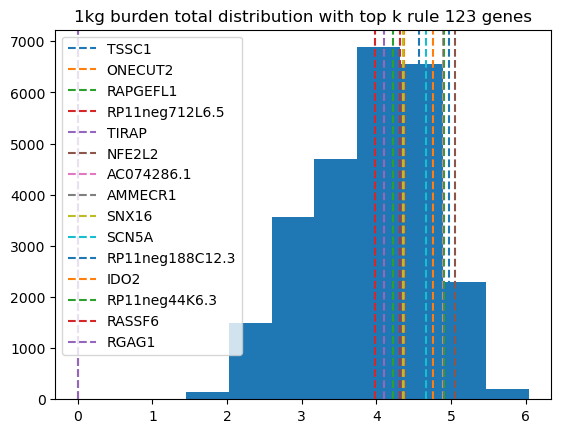

In [729]:
df_1kg_burd_tot['log_count'].hist()
cmap = plt.get_cmap('tab10')  # You can choose any colormap you like
colors = cmap.colors
color_map = {g: colors[i % len(colors)] for i, g in enumerate(g_rule3)}

for g,bt in zip(g_rule3, burden_total_rule3):
    plt.axvline(x=bt, color=color_map[g], linestyle='--')
plt.title('1kg burden total distribution with top k rule 123 genes')
plt.grid(False)
plt.legend(g_rule3)

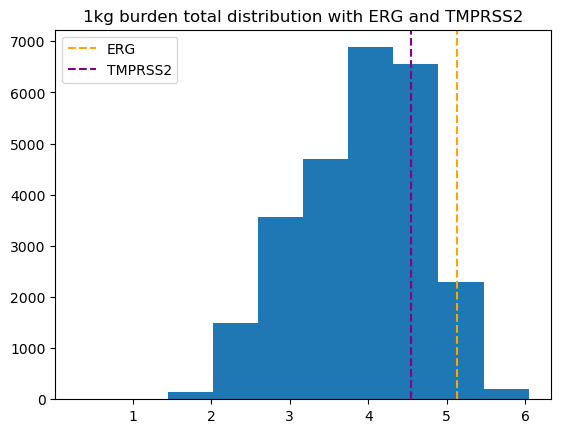

In [730]:
a = np.log10(lookup_total(df_1kg_burd_tot, 'ERG'))
b = np.log10(lookup_total(df_1kg_burd_tot, 'TMPRSS2'))
df_1kg_burd_tot['log_count'].hist()
plt.axvline(x=a, color='orange', linestyle='--')
plt.axvline(x=b, color='purple', linestyle='--')
plt.title('1kg burden total distribution with ERG and TMPRSS2')
plt.grid(False)
plt.legend(['ERG', 'TMPRSS2'])

In [697]:
x = df_1kg_burd_tot['gene'].str.contains('AMMECR1')
df_1kg_burd_tot[x]

,gene,count,log_count
1798,AMMECR1L,15727,4.196646


6.184698527074687 5.590588849753433


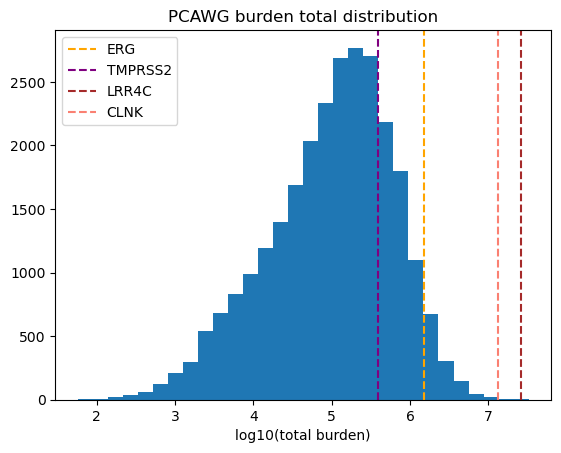

In [663]:
df_pcawg_burd_tot['log_count'] = df_pcawg_burd_tot['count'].apply(np.log10)
df_pcawg_burd_tot['log_count'].hist(bins=30)
mu_tot_pcawg = df_pcawg_burd_tot['count'].mean()
sigma_tot_pcawg = df_pcawg_burd_tot['count'].std()
mu_tot_pcawg_log = df_pcawg_burd_tot['log_count'].mean()
sigma_tot_pcawg_log = df_pcawg_burd_tot['log_count'].std()

erg_mask = df_pcawg_burd_tot['gene'] == 'ERG'
tmprss2_mask = df_pcawg_burd_tot['gene'] == 'TMPRSS2'
lrrc4c_mask = df_pcawg_burd_tot['gene'] == 'LRRC4C'
clnk_mask = df_pcawg_burd_tot['gene'] == 'CLNK'
a = df_pcawg_burd_tot[erg_mask].iloc[0,2]
b= df_pcawg_burd_tot[tmprss2_mask].iloc[0,2]
c = df_pcawg_burd_tot[lrrc4c_mask].iloc[0,2]
d= df_pcawg_burd_tot[clnk_mask].iloc[0,2]

print(a,b)
plt.title('PCAWG burden total distribution')
plt.axvline(x=a, color='orange', linestyle='--')
plt.axvline(x=b, color='purple', linestyle='--')
plt.axvline(x=c, color='brown', linestyle='--')
plt.axvline(x=d, color='salmon', linestyle='--')
plt.xlabel('log10(total burden)')
plt.legend(['ERG', 'TMPRSS2', 'LRR4C', 'CLNK'])
plt.grid(False)

In [669]:
df_1kg_burd_tot

NameError: name 'df_1kg_burd_tot' is not defined

## Within gene burden

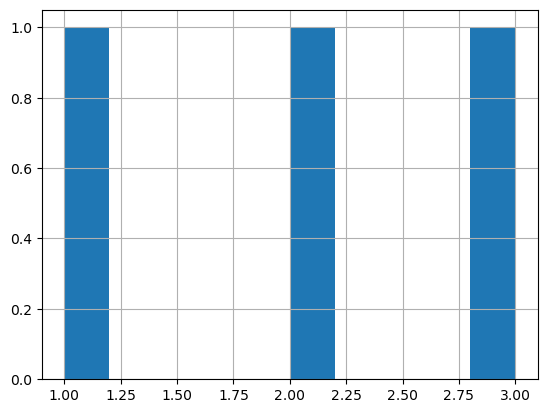

<Figure size 640x480 with 0 Axes>

In [ ]:
def p():
    fig = pd.Series([1,2,3]).hist()
    return fig
f = p()

Text(0.5, 1.0, '1kg burden within ERG (TMPRSS2 marked)')

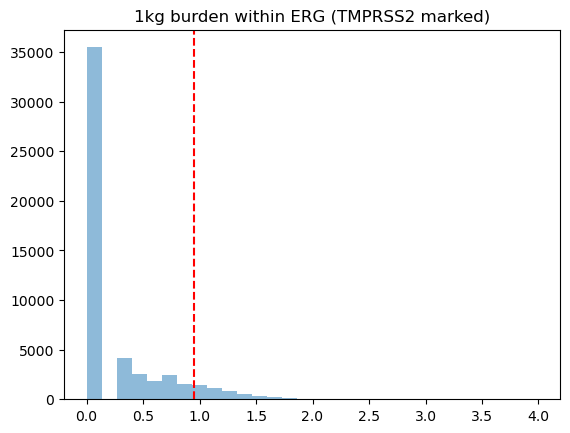

In [793]:
# get gene2gene burden count distribution for a specific gene
def burden_within(X, gene, target = None, log=True,bins=30,alpha=0.5, vline_color='red', fname = None):
    as_source = X.loc[gene,:]
    as_target = X.loc[:,gene]
    s = pd.concat([as_source, as_target])
    if log:
        s = s.apply(lambda x: np.log10(x+1))
    s.hist(bins=bins,alpha=alpha)
    if target:
        t = s.loc[target]
        plt.axvline(x=t.values[0], color=vline_color, linestyle='--')
        plt.grid(False)
    if fname:
        plt.savefig(fname)

fname = os.path.join(dir_fig, '1kg-burden_within_ERG.png')
burden_within(H, 'ERG','TMPRSS2', True,fname=fname)
plt.title('1kg burden within ERG (TMPRSS2 marked)')

Text(0.5, 1.0, 'PCAWG burden within ERG (TMPRSS2 marked)')

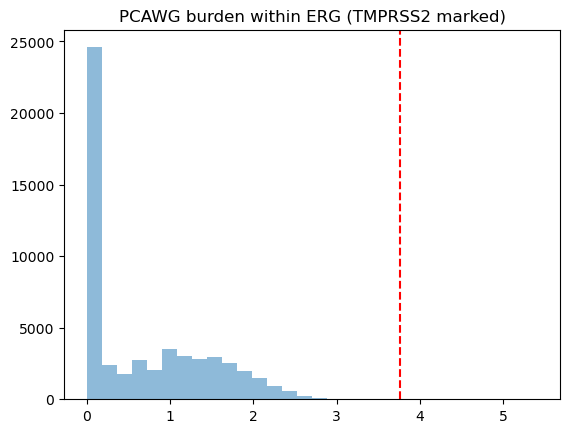

In [794]:
fname = os.path.join(dir_fig, 'PCAWG-burden_within_ERG.png')
burden_within(C, 'ERG','TMPRSS2', True, bins=30, fname=fname)
plt.title('PCAWG burden within ERG (TMPRSS2 marked)')

## Rule 4? 

- Require within burden in C to be above 95th percentile

In [792]:
X_rule3_topk

,g_i,g_j,count
0,TSSC1,SNX16,167850
1,ONECUT2,SCN5A,59707
2,RAPGEFL1,RP11neg188C12.3,38758
3,RP11neg712L6.5,IDO2,37860
4,TIRAP,IDO2,37860
5,RP11neg712L6.5,RP11neg44K6.3,37857
6,TIRAP,RP11neg44K6.3,37857
7,NFE2L2,RASSF6,35578
8,AC074286.1,RASSF6,35565
9,AMMECR1,RGAG1,35402


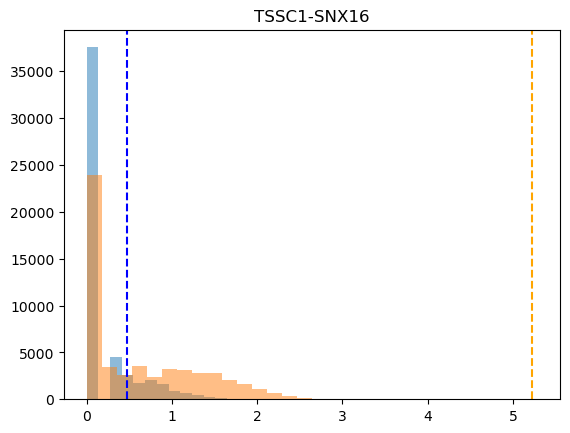

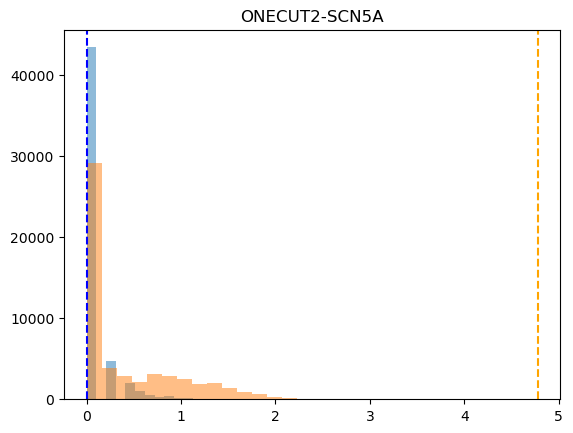

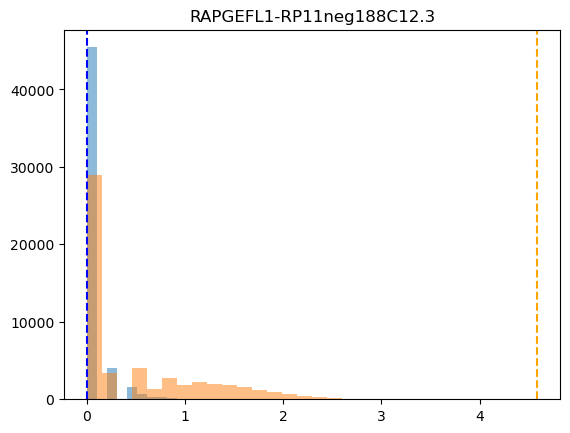

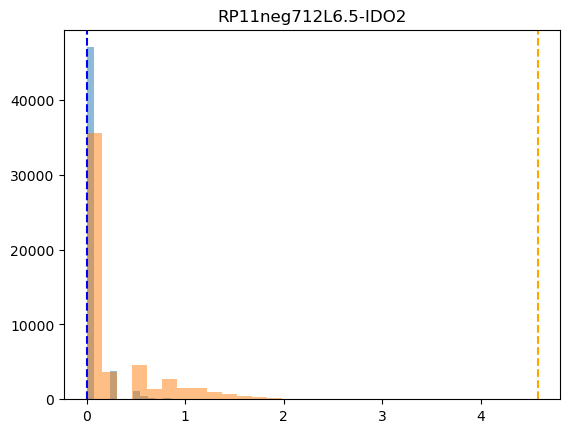

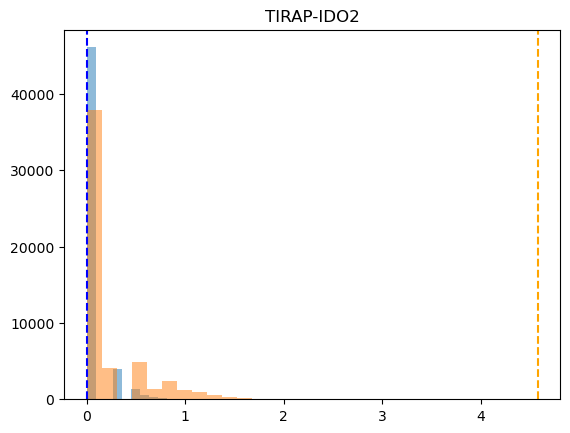

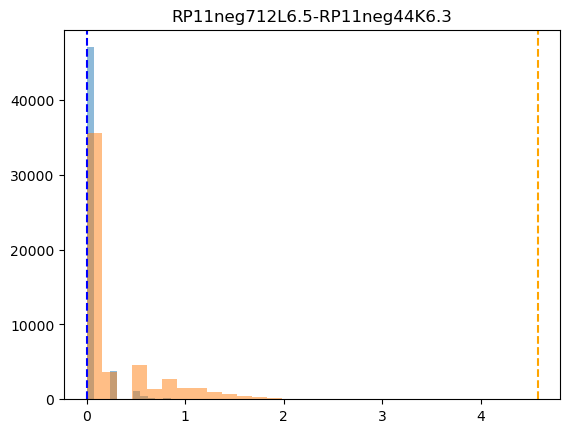

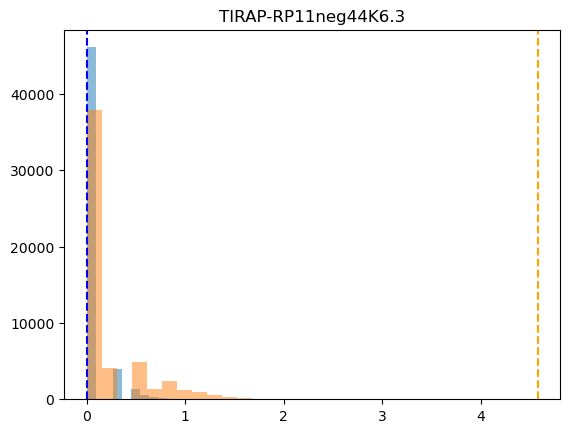

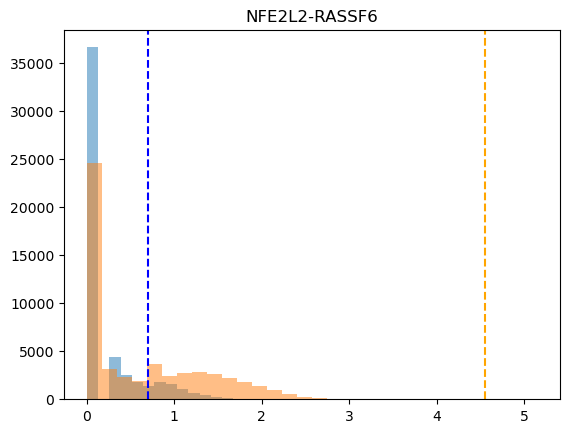

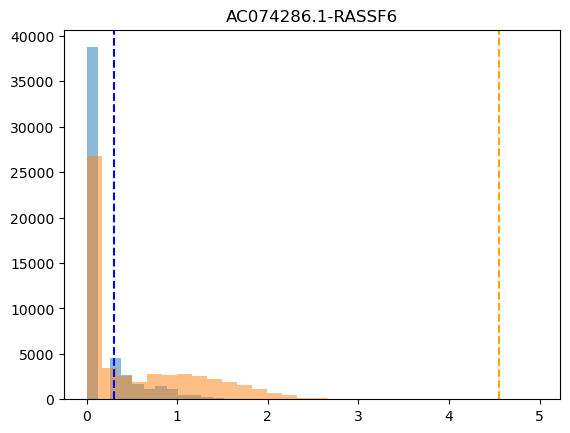

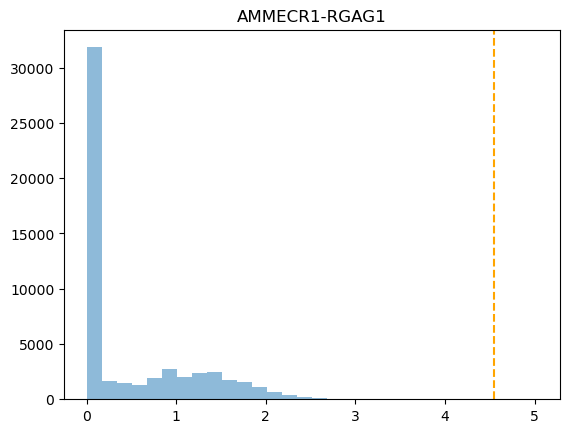

In [796]:
for g_i, g_j in zip(X_rule3_topk['g_i'], X_rule3_topk['g_j']):
    if ((g_i) in H.index) and ((g_j) in H.index):
        burden_within(H, g_i, g_j, True, bins=30, vline_color='blue',
                      fname=os.path.join(dir_fig, f'1kg-burden_within_{g_i}-{g_j}.png'))
        plt.title(f'{g_i}-{g_j}')
    burden_within(C, g_i, g_j, True, bins=30, vline_color='orange',
                  fname=os.path.join(dir_fig, f'PCAWG-burden_within_{g_i}-{g_j}.png'))
    plt.title(f'{g_i}-{g_j}')
    plt.show()

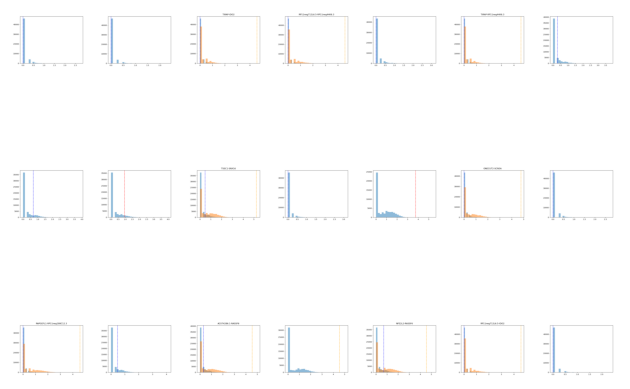

In [ ]:
image_files = glob.glob(os.path.join(dir_fig, '*.png'))
#sq = int(np.ceil(np.sqrt(len(image_files))))
fig, axs = plt.subplots(3, 7)
i = 0
for ax, f in zip(axs.flatten(), image_files):
    img = Image.open(f)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()